In [1]:
!pip install catboost

In [2]:
#load necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

import os, sys
import warnings

warnings.filterwarnings('ignore')

In [3]:
#load dataset
churn = pd.read_csv('banking_churn.csv')
data = churn.copy()

In [4]:
#check size of the observation and variable
data.shape

(10000, 14)

In [5]:
#load the first 5 data in the dataset
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
#load columns in the datasets
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [7]:
#load information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
# observation
#checking for missing data
data.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [9]:
data.drop(["RowNumber","CustomerId","Surname"], axis = 1 , inplace = True)
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [10]:
#statistics of the data
stats = data.describe()
stats

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<AxesSubplot:xlabel='Exited', ylabel='count'>

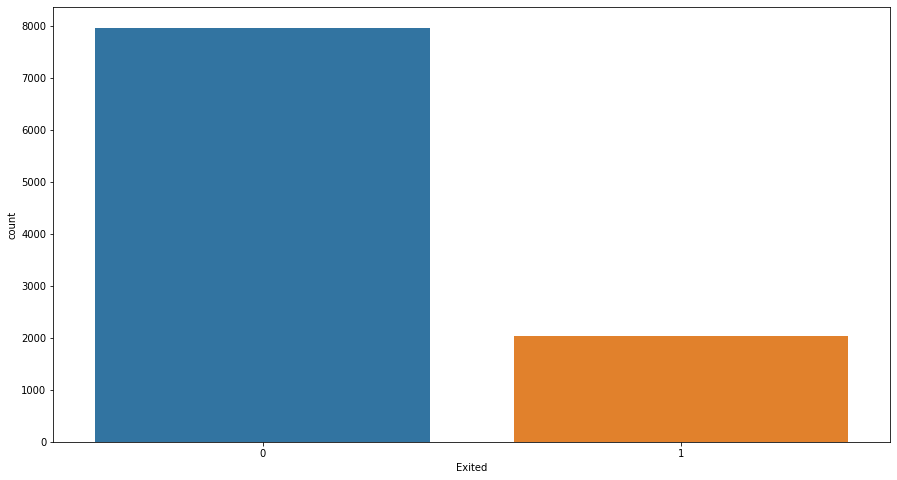

In [11]:
# VISUALIZATION
# Analyzing target variable
plt.figure(figsize = (15,8))
sns.countplot('Exited', data = data)

Male      5457
Female    4543
Name: Gender, dtype: int64


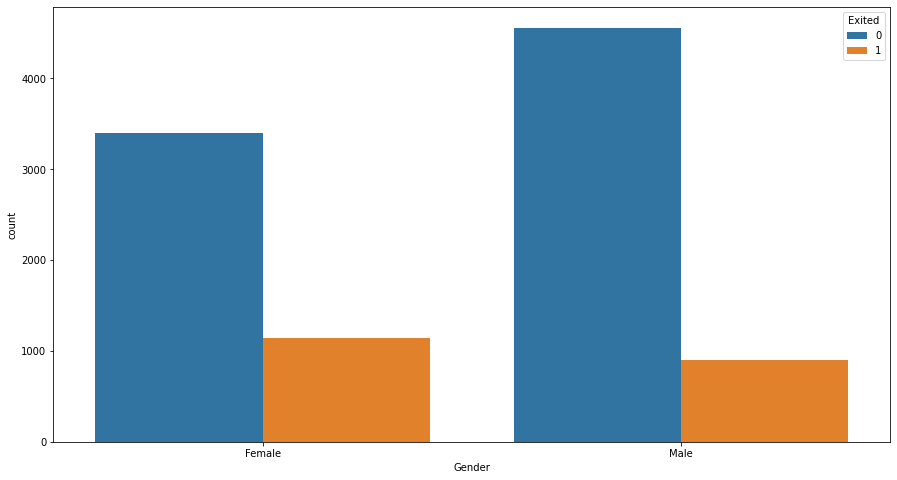

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64


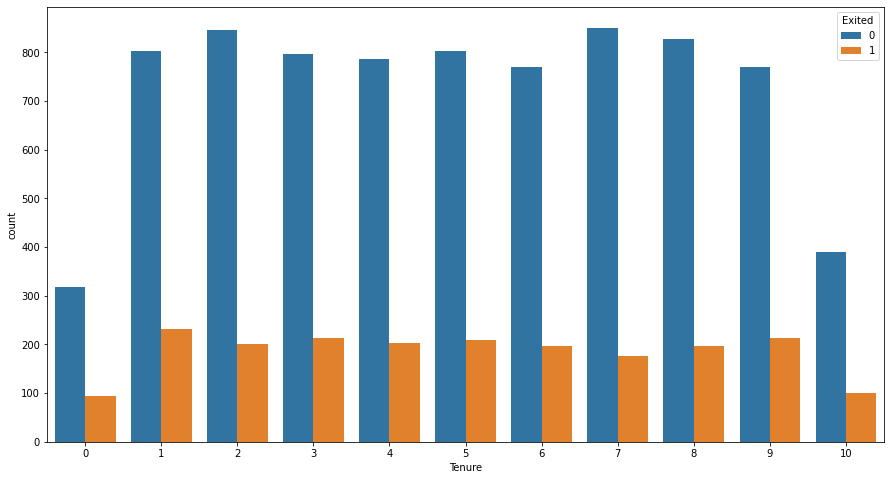

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64


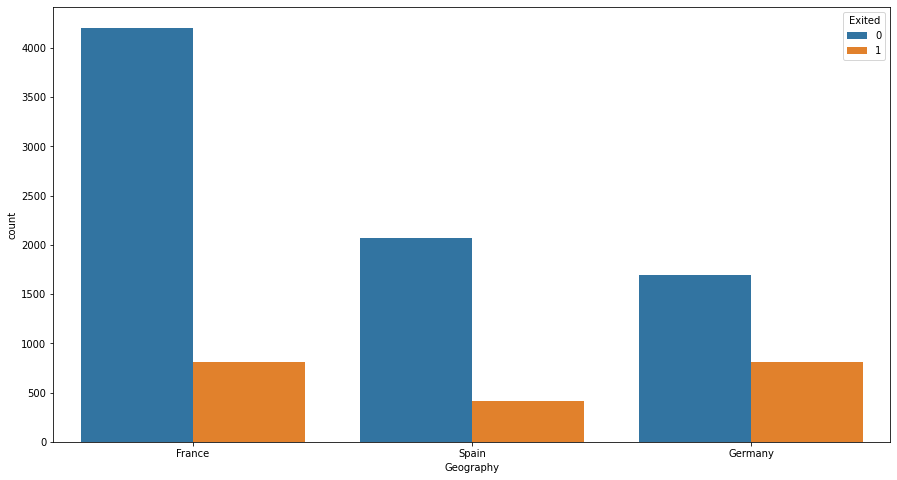

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64


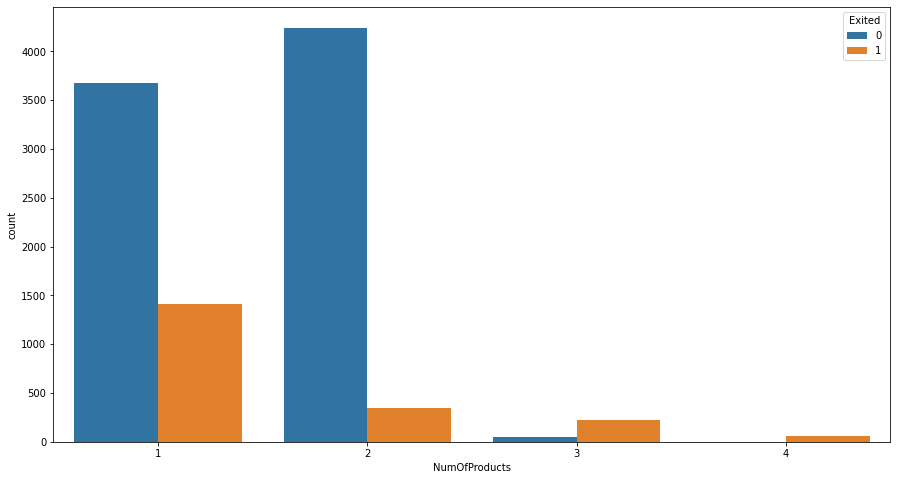

1    7055
0    2945
Name: HasCrCard, dtype: int64


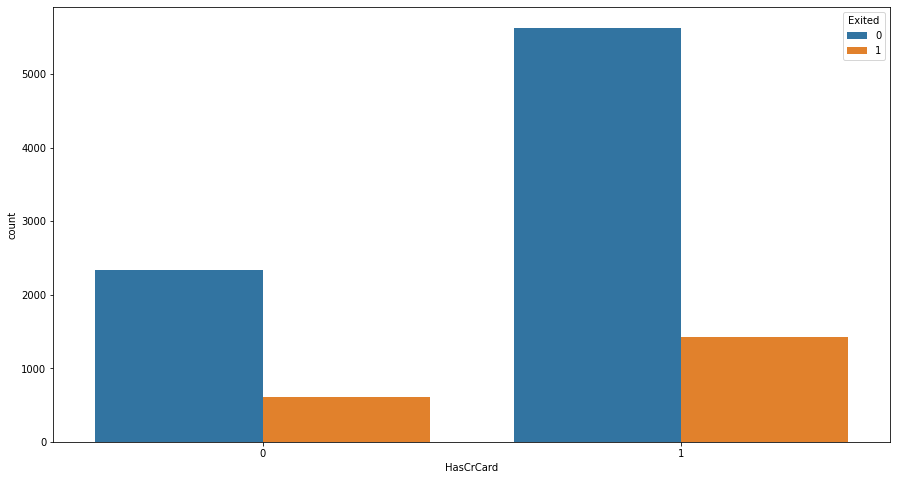

1    5151
0    4849
Name: IsActiveMember, dtype: int64


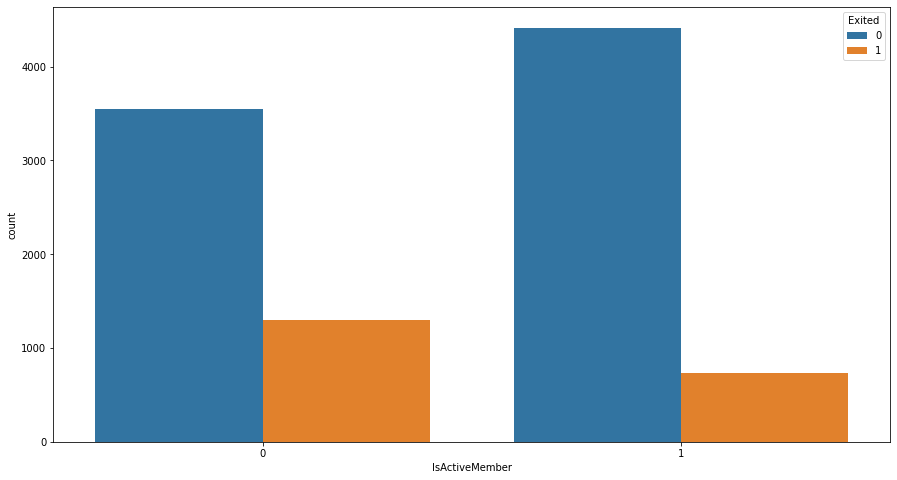

In [12]:
## Analyzing how categorical data relates with the target variable (exited)
cat_data = data[['Gender', 'Tenure', 'Geography', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']]


def categorical(var):
    print(data[var].value_counts())

    plt.figure(figsize=(15, 8))
    sns.countplot(x=var, data=data, hue='Exited')
    plt.show()


for i in cat_data:
    categorical(i)

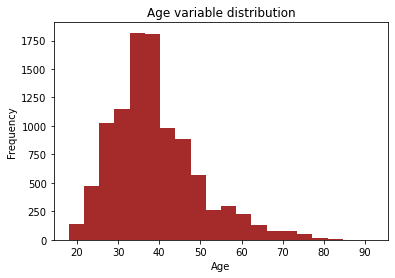

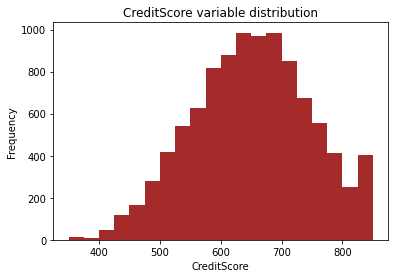

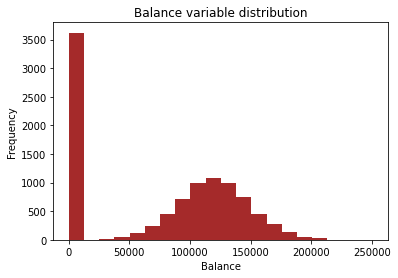

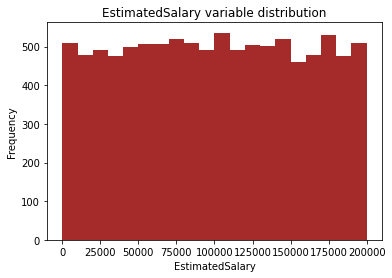

In [13]:
# Analyzing numerical data
Num_data = data[['Age', 'CreditScore', 'Balance', 'EstimatedSalary']]


def numerical(var):
    plt.hist(data[var], bins=20, color="brown")
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title("{} variable distribution".format(var))
    plt.show()


for i in Num_data:
    numerical(i)

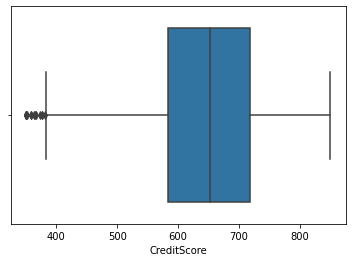

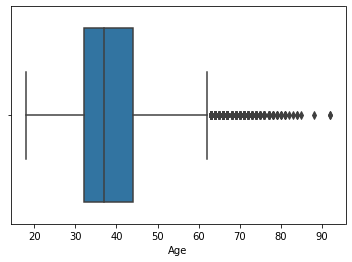

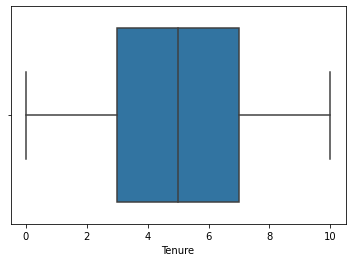

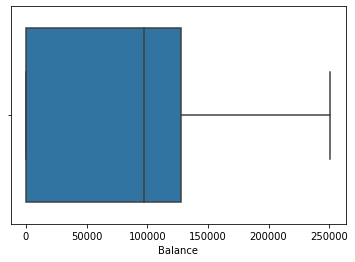

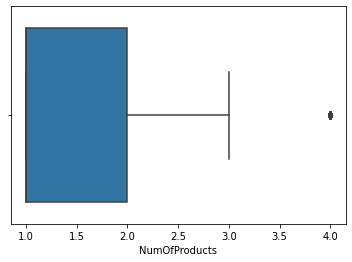

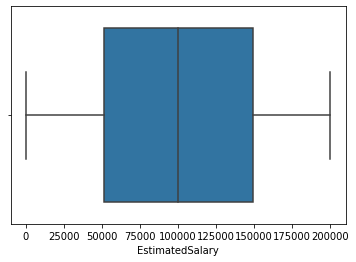

In [14]:
list_order = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


def viz_outliers(var):
    sns.boxplot(data[var])
    plt.show()


for i in list_order:
    viz_outliers(i)

In [15]:
# Seems like CreditScore, Age, NumOfProducts have outliers
outliers = ['Age', 'CreditScore', 'NumOfProducts']


# create a function to remove the outliers
def outlier_removal(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    point_low = q1 - 1.5 * iqr
    point_high = q3 + 1.5 * iqr
    cleaned_data = data.loc[(data[column] > point_low) & (data[column] < point_high)]
    return cleaned_data


In [16]:
# Seems like CreditScore, Age, NumOfProducts have outliers
outliers = ['Age', 'CreditScore', 'NumOfProducts']


# create a function to remove the outliers
def outlier_removal(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    point_low = q1 - 1.5 * iqr
    point_high = q3 + 1.5 * iqr
    cleaned_data = data.loc[(data[column] > point_low) & (data[column] < point_high)]
    return cleaned_data


# clean the dataset by removing outliers
data_cleaned = outlier_removal(outlier_removal(outlier_removal(data, 'Age'), 'CreditScore'), 'NumOfProducts')

print(data.shape)
print(data_cleaned.shape)

(10000, 11)
(9516, 11)


<AxesSubplot:>

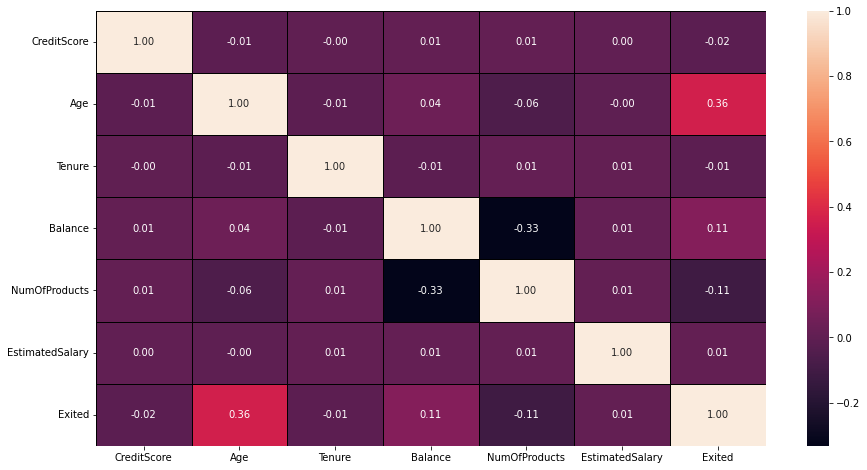

In [17]:
# CORRELATION MATRIX OF THE DATA
plt.figure(figsize = (15,8))
list_corr = ['CreditScore' ,'Age' ,'Tenure' ,'Balance' ,'NumOfProducts' ,'EstimatedSalary' ,'Exited']
sns.heatmap(data_cleaned[list_corr].corr(), annot = True, linecolor = "black", lw = 0.5, fmt= '.2f')

<AxesSubplot:xlabel='Age', ylabel='Exited'>

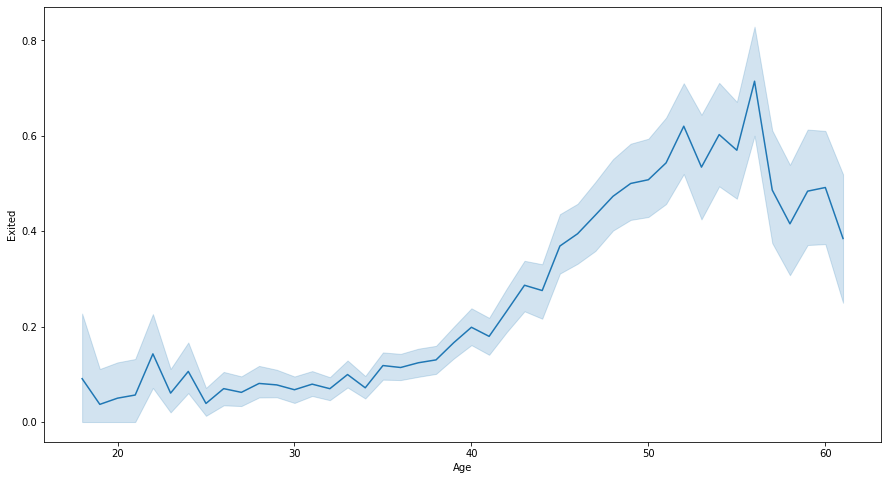

In [18]:
## Analyzing how numerical variable relates with the target variable (exited)
# AGE AND EXIT
plt.figure(figsize = (15,8))
sns.lineplot(x = "Age", y = "Exited", data = data_cleaned)

In [19]:
data_cleaned.groupby(data_cleaned["Exited"])["Age"].mean()

Exited
0    36.089197
1    43.793583
Name: Age, dtype: float64

In [20]:
# FEATURE ENGINEERING
# since geography is a categorical data lets one-hot encode it by using pd.get_dummies
data_cleaned = pd.get_dummies(data_cleaned, columns = ['Geography'])

# since gender is a categorical data lets label encode it as female = 1 and male = 0
def func(data_cleaned):
    d =[]
    for m in data_cleaned:
        if m =='Female':
            d.append(1)
        else:
            d.append(0)
    return d

data_cleaned['Gender'] = func(data_cleaned['Gender'])

In [21]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9516 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9516 non-null   int64  
 1   Gender             9516 non-null   int64  
 2   Age                9516 non-null   int64  
 3   Tenure             9516 non-null   int64  
 4   Balance            9516 non-null   float64
 5   NumOfProducts      9516 non-null   int64  
 6   HasCrCard          9516 non-null   int64  
 7   IsActiveMember     9516 non-null   int64  
 8   EstimatedSalary    9516 non-null   float64
 9   Exited             9516 non-null   int64  
 10  Geography_France   9516 non-null   uint8  
 11  Geography_Germany  9516 non-null   uint8  
 12  Geography_Spain    9516 non-null   uint8  
dtypes: float64(2), int64(8), uint8(3)
memory usage: 1.1 MB


In [22]:
# MODELLING
x = data_cleaned.drop('Exited', axis=1)
y = data_cleaned['Exited']
#splitting data into test and train set
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42
                                                    )

In [23]:
# LogisticRegression
Lr = LogisticRegression() # algorithm instantiation
Lr.fit(x_train, y_train) # model learning

# make your predictions on the test data
pred = Lr.predict(x_test)

print(classification_report(y_test, pred, digits=2))

# evaluate the test data using accuracy score
print("Accuracy score of Logistic Regression model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      2277
           1       0.50      0.09      0.16       578

    accuracy                           0.80      2855
   macro avg       0.66      0.54      0.52      2855
weighted avg       0.75      0.80      0.74      2855

Accuracy score of Logistic Regression model:  0.7978984238178634


In [24]:
#Perform feature scaling (standardization) using standardscalar()
sc = StandardScaler()
xstandard_train = sc.fit_transform(x_train)
xstandard_test = sc.transform (x_test)

In [25]:
Lr_s = LogisticRegression() # algorithm instantiation
Lr_s.fit(xstandard_train, y_train)

pred = Lr_s.predict(xstandard_test)

print(classification_report(y_test, pred, digits=2))
Lr_score = accuracy_score(y_test, pred)
print("Accuracy score of Standardised Logistic Regression model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2277
           1       0.70      0.27      0.39       578

    accuracy                           0.83      2855
   macro avg       0.77      0.62      0.64      2855
weighted avg       0.81      0.83      0.80      2855

Accuracy score of Standardised Logistic Regression model:  0.8287215411558669


In [26]:
# SVC
svc = SVC(probability = True) # algorithm instantiation
svc.fit(xstandard_train, y_train)

pred = svc.predict(xstandard_test)

print(classification_report(y_test, pred, digits=2))
svc_score = accuracy_score(y_test, pred)
print("Accuracy score of SVC model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      2277
           1       0.81      0.35      0.49       578

    accuracy                           0.85      2855
   macro avg       0.83      0.66      0.70      2855
weighted avg       0.85      0.85      0.83      2855

Accuracy score of SVC model:  0.8518388791593695


In [27]:
#KNN
knn = KNeighborsClassifier(n_neighbors = 5) # algorithm instantiation
knn.fit(xstandard_train, y_train)

pred = knn.predict(xstandard_test)

print(classification_report(y_test, pred, digits=2))
knn_score = accuracy_score(y_test, pred)
print("Accuracy score of KNN model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      2277
           1       0.60      0.33      0.42       578

    accuracy                           0.82      2855
   macro avg       0.73      0.64      0.66      2855
weighted avg       0.80      0.82      0.80      2855

Accuracy score of KNN model:  0.8203152364273205


In [28]:
# RandomForestClassifier
rand = RandomForestClassifier(random_state = 42)

rand.fit(x_train, y_train)
pred = rand.predict(x_test)

print(classification_report(y_test, pred, digits=2))
rand_score = accuracy_score(y_test, pred)
print("Accuracy score of Random Forest model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2277
           1       0.77      0.45      0.57       578

    accuracy                           0.86      2855
   macro avg       0.82      0.71      0.74      2855
weighted avg       0.85      0.86      0.85      2855

Accuracy score of Random Forest model:  0.8619964973730297


In [29]:
rand = RandomForestClassifier(random_state = 42, max_depth = 10, n_estimators = 1000)

rand.fit(x, y)

scoreRand = cross_val_score(rand, x, y, cv=5, scoring='accuracy')
print ('The mean value of cross val score is {}'.format(scoreRand.mean()))

The mean value of cross val score is 0.8645439310774231


In [30]:
# XGBClassifier
xgb =XGBClassifier(learning_rate=0.01,n_estimators=200,
                            max_depth=5, eval_metric="logloss")

xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)

print(classification_report(y_test, pred, digits=2))
xgb_score = accuracy_score(y_test, pred)
print("Accuracy score of XGB model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2277
           1       0.80      0.42      0.55       578

    accuracy                           0.86      2855
   macro avg       0.84      0.70      0.73      2855
weighted avg       0.86      0.86      0.84      2855

Accuracy score of XGB model:  0.861646234676007


In [31]:
xgb =XGBClassifier()
xgb.fit(x, y)

scoreXGB = cross_val_score(xgb, x, y, cv=10, scoring='accuracy')
print ('The mean value of cross val score is {}'.format(scoreXGB.mean()))

The mean value of cross val score is 0.8505658572577296


In [32]:
# GradientBoostingClassifier
model_grb = GradientBoostingClassifier()

model_grb.fit(x_train,y_train)

pred = model_grb.predict(x_test)

print(classification_report(y_test, pred, digits=2))
grb_score = accuracy_score(y_test, pred)
print("Accuracy score of Gradient Boost model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2277
           1       0.78      0.44      0.56       578

    accuracy                           0.86      2855
   macro avg       0.83      0.70      0.74      2855
weighted avg       0.85      0.86      0.85      2855

Accuracy score of Gradient Boost model:  0.8612959719789842


In [33]:
model_grb = GradientBoostingClassifier()
model_grb.fit(x, y)

scoreGRB = cross_val_score(model_grb, x, y, cv=10, scoring='accuracy')
print ('The mean value of cross val score is {}'.format(scoreGRB.mean()))

The mean value of cross val score is 0.8620208493492034


In [34]:
# LGBM_Model
lgbm_model = LGBMClassifier(silent = 0, learning_rate = 0.09, max_delta_step = 2, n_estimators = 100, boosting_type = 'gbdt',
                            max_depth = 10, eval_metric = "logloss", gamma = 3, base_score = 0.5)

lgbm_model.fit(x_train, y_train)
y_pred = lgbm_model.predict(x_test)
print(classification_report(y_test, y_pred, digits=2))
lgbm_score = accuracy_score(y_test, y_pred)
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1292, number of negative: 5369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 6661, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193965 -> initscore=-1.424450
[Li

In [35]:
# CatBoostClassifier
#Instantiate CatBoostClassifier
catboost = CatBoostClassifier()

#create the grid
grid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = catboost, param_grid = grid, scoring ='accuracy', cv = 5)

#fit the model
gscv.fit(x_train,y_train)

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

Learning rate set to 0.173851
0:	learn: 0.6162379	total: 144ms	remaining: 14.2s
1:	learn: 0.5622431	total: 148ms	remaining: 7.25s
2:	learn: 0.5173316	total: 152ms	remaining: 4.91s
3:	learn: 0.4862038	total: 158ms	remaining: 3.79s
4:	learn: 0.4619725	total: 162ms	remaining: 3.08s
5:	learn: 0.4442574	total: 169ms	remaining: 2.64s
6:	learn: 0.4278310	total: 171ms	remaining: 2.27s
7:	learn: 0.4156854	total: 175ms	remaining: 2.01s
8:	learn: 0.4043411	total: 177ms	remaining: 1.79s
9:	learn: 0.3971363	total: 180ms	remaining: 1.62s
10:	learn: 0.3898136	total: 183ms	remaining: 1.48s
11:	learn: 0.3836185	total: 185ms	remaining: 1.36s
12:	learn: 0.3779447	total: 188ms	remaining: 1.25s
13:	learn: 0.3730903	total: 190ms	remaining: 1.17s
14:	learn: 0.3703635	total: 193ms	remaining: 1.09s
15:	learn: 0.3670254	total: 195ms	remaining: 1.02s
16:	learn: 0.3630980	total: 198ms	remaining: 964ms
17:	learn: 0.3613140	total: 200ms	remaining: 912ms
18:	learn: 0.3596211	total: 203ms	remaining: 865ms
19:	learn: 

92:	learn: 0.3171232	total: 198ms	remaining: 14.9ms
93:	learn: 0.3170808	total: 201ms	remaining: 12.8ms
94:	learn: 0.3170604	total: 202ms	remaining: 10.6ms
95:	learn: 0.3169602	total: 204ms	remaining: 8.49ms
96:	learn: 0.3169229	total: 205ms	remaining: 6.35ms
97:	learn: 0.3166602	total: 207ms	remaining: 4.22ms
98:	learn: 0.3162099	total: 208ms	remaining: 2.1ms
99:	learn: 0.3160014	total: 210ms	remaining: 0us
Learning rate set to 0.173865
0:	learn: 0.6167725	total: 2.48ms	remaining: 246ms
1:	learn: 0.5621080	total: 5.63ms	remaining: 276ms
2:	learn: 0.5169833	total: 7.88ms	remaining: 255ms
3:	learn: 0.4838189	total: 9.67ms	remaining: 232ms
4:	learn: 0.4590083	total: 11.8ms	remaining: 225ms
5:	learn: 0.4396341	total: 14.5ms	remaining: 226ms
6:	learn: 0.4238373	total: 16.8ms	remaining: 224ms
7:	learn: 0.4121120	total: 19ms	remaining: 219ms
8:	learn: 0.4007310	total: 21.6ms	remaining: 219ms
9:	learn: 0.3940129	total: 23.4ms	remaining: 210ms
10:	learn: 0.3851209	total: 25ms	remaining: 202ms


91:	learn: 0.3170997	total: 186ms	remaining: 16.2ms
92:	learn: 0.3169565	total: 189ms	remaining: 14.2ms
93:	learn: 0.3167070	total: 190ms	remaining: 12.2ms
94:	learn: 0.3163776	total: 192ms	remaining: 10.1ms
95:	learn: 0.3161233	total: 193ms	remaining: 8.06ms
96:	learn: 0.3159636	total: 196ms	remaining: 6.05ms
97:	learn: 0.3158827	total: 197ms	remaining: 4.02ms
98:	learn: 0.3155254	total: 198ms	remaining: 2ms
99:	learn: 0.3153950	total: 200ms	remaining: 0us
Learning rate set to 0.173865
0:	learn: 0.6174832	total: 2.36ms	remaining: 233ms
1:	learn: 0.5641938	total: 4.8ms	remaining: 235ms
2:	learn: 0.5189831	total: 7.13ms	remaining: 230ms
3:	learn: 0.4855830	total: 9.39ms	remaining: 225ms
4:	learn: 0.4610584	total: 10.8ms	remaining: 205ms
5:	learn: 0.4423821	total: 12.6ms	remaining: 197ms
6:	learn: 0.4254436	total: 14.6ms	remaining: 194ms
7:	learn: 0.4131185	total: 16.9ms	remaining: 194ms
8:	learn: 0.4022457	total: 18.8ms	remaining: 190ms
9:	learn: 0.3949516	total: 20.2ms	remaining: 182ms

83:	learn: 0.3264919	total: 279ms	remaining: 386ms
84:	learn: 0.3263728	total: 283ms	remaining: 383ms
85:	learn: 0.3261316	total: 286ms	remaining: 379ms
86:	learn: 0.3256873	total: 288ms	remaining: 374ms
87:	learn: 0.3254484	total: 291ms	remaining: 370ms
88:	learn: 0.3249481	total: 293ms	remaining: 366ms
89:	learn: 0.3247545	total: 296ms	remaining: 362ms
90:	learn: 0.3246138	total: 299ms	remaining: 358ms
91:	learn: 0.3244640	total: 301ms	remaining: 354ms
92:	learn: 0.3238662	total: 304ms	remaining: 350ms
93:	learn: 0.3236034	total: 308ms	remaining: 348ms
94:	learn: 0.3234771	total: 312ms	remaining: 345ms
95:	learn: 0.3233091	total: 315ms	remaining: 341ms
96:	learn: 0.3230754	total: 319ms	remaining: 338ms
97:	learn: 0.3229620	total: 321ms	remaining: 335ms
98:	learn: 0.3227954	total: 325ms	remaining: 332ms
99:	learn: 0.3222679	total: 328ms	remaining: 328ms
100:	learn: 0.3219902	total: 331ms	remaining: 324ms
101:	learn: 0.3218149	total: 335ms	remaining: 322ms
102:	learn: 0.3216018	total: 

66:	learn: 0.3270688	total: 226ms	remaining: 448ms
67:	learn: 0.3267554	total: 228ms	remaining: 444ms
68:	learn: 0.3265344	total: 231ms	remaining: 439ms
69:	learn: 0.3261521	total: 234ms	remaining: 434ms
70:	learn: 0.3257465	total: 237ms	remaining: 430ms
71:	learn: 0.3254556	total: 239ms	remaining: 425ms
72:	learn: 0.3253463	total: 242ms	remaining: 420ms
73:	learn: 0.3250179	total: 244ms	remaining: 416ms
74:	learn: 0.3248250	total: 247ms	remaining: 412ms
75:	learn: 0.3246848	total: 250ms	remaining: 408ms
76:	learn: 0.3244986	total: 254ms	remaining: 406ms
77:	learn: 0.3238841	total: 257ms	remaining: 403ms
78:	learn: 0.3235902	total: 261ms	remaining: 400ms
79:	learn: 0.3234666	total: 265ms	remaining: 398ms
80:	learn: 0.3232482	total: 269ms	remaining: 395ms
81:	learn: 0.3230554	total: 272ms	remaining: 391ms
82:	learn: 0.3228423	total: 275ms	remaining: 388ms
83:	learn: 0.3224842	total: 279ms	remaining: 385ms
84:	learn: 0.3218815	total: 282ms	remaining: 382ms
85:	learn: 0.3217882	total: 286

32:	learn: 0.3459418	total: 113ms	remaining: 571ms
33:	learn: 0.3453829	total: 117ms	remaining: 571ms
34:	learn: 0.3448328	total: 120ms	remaining: 564ms
35:	learn: 0.3440770	total: 122ms	remaining: 557ms
36:	learn: 0.3434882	total: 125ms	remaining: 550ms
37:	learn: 0.3430148	total: 128ms	remaining: 545ms
38:	learn: 0.3423232	total: 131ms	remaining: 539ms
39:	learn: 0.3419009	total: 134ms	remaining: 534ms
40:	learn: 0.3407129	total: 136ms	remaining: 529ms
41:	learn: 0.3393097	total: 141ms	remaining: 530ms
42:	learn: 0.3387073	total: 144ms	remaining: 526ms
43:	learn: 0.3382159	total: 148ms	remaining: 523ms
44:	learn: 0.3378297	total: 151ms	remaining: 521ms
45:	learn: 0.3372824	total: 155ms	remaining: 518ms
46:	learn: 0.3370424	total: 158ms	remaining: 515ms
47:	learn: 0.3368574	total: 162ms	remaining: 513ms
48:	learn: 0.3366439	total: 165ms	remaining: 510ms
49:	learn: 0.3363662	total: 169ms	remaining: 506ms
50:	learn: 0.3360483	total: 172ms	remaining: 502ms
51:	learn: 0.3358292	total: 175

Learning rate set to 0.09208
0:	learn: 0.6361080	total: 4.46ms	remaining: 887ms
1:	learn: 0.5926481	total: 8.42ms	remaining: 834ms
2:	learn: 0.5476801	total: 12.5ms	remaining: 819ms
3:	learn: 0.5121309	total: 16.9ms	remaining: 828ms
4:	learn: 0.4878111	total: 20.2ms	remaining: 788ms
5:	learn: 0.4652540	total: 24.1ms	remaining: 780ms
6:	learn: 0.4488639	total: 27.9ms	remaining: 769ms
7:	learn: 0.4334412	total: 31.6ms	remaining: 759ms
8:	learn: 0.4224672	total: 36.1ms	remaining: 766ms
9:	learn: 0.4132363	total: 40.1ms	remaining: 762ms
10:	learn: 0.4069252	total: 44.2ms	remaining: 760ms
11:	learn: 0.3997075	total: 47.8ms	remaining: 749ms
12:	learn: 0.3959317	total: 51.7ms	remaining: 744ms
13:	learn: 0.3907746	total: 56.6ms	remaining: 751ms
14:	learn: 0.3857471	total: 60.7ms	remaining: 748ms
15:	learn: 0.3816584	total: 65.2ms	remaining: 749ms
16:	learn: 0.3783408	total: 68.3ms	remaining: 735ms
17:	learn: 0.3756305	total: 73ms	remaining: 738ms
18:	learn: 0.3719962	total: 77.1ms	remaining: 7

186:	learn: 0.3058047	total: 680ms	remaining: 47.3ms
187:	learn: 0.3056452	total: 683ms	remaining: 43.6ms
188:	learn: 0.3055298	total: 686ms	remaining: 39.9ms
189:	learn: 0.3052863	total: 689ms	remaining: 36.2ms
190:	learn: 0.3051140	total: 691ms	remaining: 32.6ms
191:	learn: 0.3050727	total: 694ms	remaining: 28.9ms
192:	learn: 0.3049098	total: 696ms	remaining: 25.3ms
193:	learn: 0.3047373	total: 699ms	remaining: 21.6ms
194:	learn: 0.3045542	total: 702ms	remaining: 18ms
195:	learn: 0.3044858	total: 706ms	remaining: 14.4ms
196:	learn: 0.3044095	total: 709ms	remaining: 10.8ms
197:	learn: 0.3042982	total: 713ms	remaining: 7.21ms
198:	learn: 0.3041265	total: 718ms	remaining: 3.61ms
199:	learn: 0.3039066	total: 722ms	remaining: 0us
Learning rate set to 0.09208
0:	learn: 0.6362894	total: 3.75ms	remaining: 747ms
1:	learn: 0.5886464	total: 7.63ms	remaining: 756ms
2:	learn: 0.5447759	total: 12.1ms	remaining: 792ms
3:	learn: 0.5157198	total: 15.4ms	remaining: 754ms
4:	learn: 0.4861978	total: 19.

167:	learn: 0.3077615	total: 572ms	remaining: 109ms
168:	learn: 0.3075982	total: 576ms	remaining: 106ms
169:	learn: 0.3074664	total: 578ms	remaining: 102ms
170:	learn: 0.3073505	total: 581ms	remaining: 98.5ms
171:	learn: 0.3072406	total: 584ms	remaining: 95.1ms
172:	learn: 0.3070882	total: 587ms	remaining: 91.6ms
173:	learn: 0.3068454	total: 590ms	remaining: 88.1ms
174:	learn: 0.3065636	total: 594ms	remaining: 84.8ms
175:	learn: 0.3064653	total: 597ms	remaining: 81.4ms
176:	learn: 0.3062285	total: 601ms	remaining: 78.1ms
177:	learn: 0.3060519	total: 604ms	remaining: 74.7ms
178:	learn: 0.3058943	total: 607ms	remaining: 71.2ms
179:	learn: 0.3057168	total: 610ms	remaining: 67.8ms
180:	learn: 0.3054991	total: 613ms	remaining: 64.3ms
181:	learn: 0.3053800	total: 616ms	remaining: 60.9ms
182:	learn: 0.3052355	total: 619ms	remaining: 57.5ms
183:	learn: 0.3051071	total: 622ms	remaining: 54.1ms
184:	learn: 0.3048891	total: 626ms	remaining: 50.8ms
185:	learn: 0.3047338	total: 630ms	remaining: 47.

165:	learn: 0.3189708	total: 547ms	remaining: 442ms
166:	learn: 0.3188499	total: 550ms	remaining: 438ms
167:	learn: 0.3187153	total: 553ms	remaining: 434ms
168:	learn: 0.3186170	total: 555ms	remaining: 431ms
169:	learn: 0.3184044	total: 558ms	remaining: 427ms
170:	learn: 0.3182984	total: 561ms	remaining: 423ms
171:	learn: 0.3181559	total: 564ms	remaining: 420ms
172:	learn: 0.3179264	total: 567ms	remaining: 416ms
173:	learn: 0.3177699	total: 570ms	remaining: 412ms
174:	learn: 0.3176398	total: 573ms	remaining: 409ms
175:	learn: 0.3175142	total: 576ms	remaining: 406ms
176:	learn: 0.3173181	total: 580ms	remaining: 403ms
177:	learn: 0.3172208	total: 584ms	remaining: 400ms
178:	learn: 0.3170872	total: 587ms	remaining: 397ms
179:	learn: 0.3169139	total: 590ms	remaining: 393ms
180:	learn: 0.3167296	total: 593ms	remaining: 390ms
181:	learn: 0.3165645	total: 596ms	remaining: 387ms
182:	learn: 0.3164435	total: 599ms	remaining: 383ms
183:	learn: 0.3163798	total: 603ms	remaining: 380ms
184:	learn: 

25:	learn: 0.3718178	total: 88.3ms	remaining: 931ms
26:	learn: 0.3686815	total: 92.3ms	remaining: 933ms
27:	learn: 0.3667877	total: 94.9ms	remaining: 921ms
28:	learn: 0.3648619	total: 97.6ms	remaining: 912ms
29:	learn: 0.3626366	total: 100ms	remaining: 901ms
30:	learn: 0.3607504	total: 103ms	remaining: 891ms
31:	learn: 0.3594985	total: 105ms	remaining: 878ms
32:	learn: 0.3585477	total: 107ms	remaining: 868ms
33:	learn: 0.3569102	total: 110ms	remaining: 859ms
34:	learn: 0.3554469	total: 112ms	remaining: 852ms
35:	learn: 0.3545156	total: 116ms	remaining: 850ms
36:	learn: 0.3528388	total: 119ms	remaining: 848ms
37:	learn: 0.3517131	total: 122ms	remaining: 843ms
38:	learn: 0.3511307	total: 126ms	remaining: 845ms
39:	learn: 0.3506272	total: 130ms	remaining: 844ms
40:	learn: 0.3496259	total: 133ms	remaining: 841ms
41:	learn: 0.3490073	total: 137ms	remaining: 840ms
42:	learn: 0.3480233	total: 141ms	remaining: 841ms
43:	learn: 0.3470751	total: 143ms	remaining: 835ms
44:	learn: 0.3462314	total:

207:	learn: 0.3087346	total: 686ms	remaining: 303ms
208:	learn: 0.3086386	total: 690ms	remaining: 300ms
209:	learn: 0.3085315	total: 693ms	remaining: 297ms
210:	learn: 0.3083950	total: 696ms	remaining: 294ms
211:	learn: 0.3083299	total: 699ms	remaining: 290ms
212:	learn: 0.3081611	total: 701ms	remaining: 286ms
213:	learn: 0.3081224	total: 704ms	remaining: 283ms
214:	learn: 0.3079714	total: 707ms	remaining: 280ms
215:	learn: 0.3078116	total: 710ms	remaining: 276ms
216:	learn: 0.3076690	total: 713ms	remaining: 273ms
217:	learn: 0.3075637	total: 716ms	remaining: 269ms
218:	learn: 0.3074820	total: 719ms	remaining: 266ms
219:	learn: 0.3072806	total: 723ms	remaining: 263ms
220:	learn: 0.3071820	total: 726ms	remaining: 259ms
221:	learn: 0.3071011	total: 729ms	remaining: 256ms
222:	learn: 0.3070032	total: 732ms	remaining: 253ms
223:	learn: 0.3068914	total: 736ms	remaining: 250ms
224:	learn: 0.3067321	total: 740ms	remaining: 247ms
225:	learn: 0.3066032	total: 744ms	remaining: 243ms
226:	learn: 

114:	learn: 0.3261318	total: 390ms	remaining: 628ms
115:	learn: 0.3259984	total: 394ms	remaining: 625ms
116:	learn: 0.3257940	total: 397ms	remaining: 620ms
117:	learn: 0.3256108	total: 399ms	remaining: 616ms
118:	learn: 0.3252741	total: 402ms	remaining: 612ms
119:	learn: 0.3250293	total: 406ms	remaining: 608ms
120:	learn: 0.3248678	total: 408ms	remaining: 604ms
121:	learn: 0.3243774	total: 411ms	remaining: 600ms
122:	learn: 0.3241698	total: 414ms	remaining: 595ms
123:	learn: 0.3239051	total: 417ms	remaining: 591ms
124:	learn: 0.3237313	total: 420ms	remaining: 588ms
125:	learn: 0.3236391	total: 423ms	remaining: 584ms
126:	learn: 0.3231927	total: 426ms	remaining: 581ms
127:	learn: 0.3230611	total: 429ms	remaining: 577ms
128:	learn: 0.3228221	total: 433ms	remaining: 574ms
129:	learn: 0.3226748	total: 437ms	remaining: 571ms
130:	learn: 0.3225111	total: 440ms	remaining: 568ms
131:	learn: 0.3223352	total: 444ms	remaining: 565ms
132:	learn: 0.3222063	total: 447ms	remaining: 562ms
133:	learn: 

284:	learn: 0.3015001	total: 978ms	remaining: 51.5ms
285:	learn: 0.3013712	total: 981ms	remaining: 48ms
286:	learn: 0.3012757	total: 984ms	remaining: 44.6ms
287:	learn: 0.3011810	total: 987ms	remaining: 41.1ms
288:	learn: 0.3010958	total: 990ms	remaining: 37.7ms
289:	learn: 0.3010238	total: 993ms	remaining: 34.2ms
290:	learn: 0.3009444	total: 996ms	remaining: 30.8ms
291:	learn: 0.3008260	total: 999ms	remaining: 27.4ms
292:	learn: 0.3006826	total: 1s	remaining: 23.9ms
293:	learn: 0.3006102	total: 1s	remaining: 20.5ms
294:	learn: 0.3005046	total: 1.01s	remaining: 17.1ms
295:	learn: 0.3004038	total: 1.01s	remaining: 13.7ms
296:	learn: 0.3003161	total: 1.01s	remaining: 10.2ms
297:	learn: 0.3001627	total: 1.02s	remaining: 6.82ms
298:	learn: 0.3000611	total: 1.02s	remaining: 3.41ms
299:	learn: 0.2999345	total: 1.02s	remaining: 0us
Learning rate set to 0.063488
0:	learn: 0.6529776	total: 3.98ms	remaining: 1.19s
1:	learn: 0.6166230	total: 8.4ms	remaining: 1.25s
2:	learn: 0.5860016	total: 11.7m

144:	learn: 0.3219528	total: 499ms	remaining: 534ms
145:	learn: 0.3218570	total: 503ms	remaining: 530ms
146:	learn: 0.3214956	total: 506ms	remaining: 527ms
147:	learn: 0.3213565	total: 509ms	remaining: 522ms
148:	learn: 0.3211688	total: 511ms	remaining: 518ms
149:	learn: 0.3209977	total: 514ms	remaining: 514ms
150:	learn: 0.3208123	total: 517ms	remaining: 510ms
151:	learn: 0.3206268	total: 520ms	remaining: 506ms
152:	learn: 0.3204645	total: 523ms	remaining: 502ms
153:	learn: 0.3204069	total: 526ms	remaining: 498ms
154:	learn: 0.3202957	total: 529ms	remaining: 495ms
155:	learn: 0.3201731	total: 532ms	remaining: 492ms
156:	learn: 0.3199558	total: 536ms	remaining: 488ms
157:	learn: 0.3197052	total: 539ms	remaining: 484ms
158:	learn: 0.3195651	total: 543ms	remaining: 481ms
159:	learn: 0.3194002	total: 547ms	remaining: 479ms
160:	learn: 0.3191993	total: 551ms	remaining: 475ms
161:	learn: 0.3190072	total: 554ms	remaining: 472ms
162:	learn: 0.3189042	total: 557ms	remaining: 469ms
163:	learn: 

1:	learn: 0.6171028	total: 7.08ms	remaining: 1.05s
2:	learn: 0.5820019	total: 11.2ms	remaining: 1.1s
3:	learn: 0.5572303	total: 13.8ms	remaining: 1.02s
4:	learn: 0.5307033	total: 16.5ms	remaining: 971ms
5:	learn: 0.5083676	total: 19ms	remaining: 929ms
6:	learn: 0.4932566	total: 21.6ms	remaining: 905ms
7:	learn: 0.4762117	total: 24.4ms	remaining: 890ms
8:	learn: 0.4618382	total: 27ms	remaining: 872ms
9:	learn: 0.4507025	total: 29.3ms	remaining: 850ms
10:	learn: 0.4421166	total: 32ms	remaining: 840ms
11:	learn: 0.4336073	total: 34.9ms	remaining: 838ms
12:	learn: 0.4254992	total: 38.9ms	remaining: 859ms
13:	learn: 0.4183871	total: 42.4ms	remaining: 866ms
14:	learn: 0.4116672	total: 46.4ms	remaining: 882ms
15:	learn: 0.4062813	total: 50.1ms	remaining: 889ms
16:	learn: 0.4021534	total: 53.7ms	remaining: 894ms
17:	learn: 0.3973335	total: 57.5ms	remaining: 901ms
18:	learn: 0.3933240	total: 61.2ms	remaining: 905ms
19:	learn: 0.3897770	total: 65.7ms	remaining: 920ms
20:	learn: 0.3863393	total: 

177:	learn: 0.3169562	total: 586ms	remaining: 402ms
178:	learn: 0.3168331	total: 589ms	remaining: 398ms
179:	learn: 0.3167206	total: 592ms	remaining: 395ms
180:	learn: 0.3165577	total: 595ms	remaining: 391ms
181:	learn: 0.3163250	total: 597ms	remaining: 387ms
182:	learn: 0.3161102	total: 600ms	remaining: 384ms
183:	learn: 0.3159656	total: 603ms	remaining: 380ms
184:	learn: 0.3158428	total: 606ms	remaining: 377ms
185:	learn: 0.3157123	total: 610ms	remaining: 374ms
186:	learn: 0.3155643	total: 614ms	remaining: 371ms
187:	learn: 0.3154388	total: 617ms	remaining: 368ms
188:	learn: 0.3152343	total: 620ms	remaining: 364ms
189:	learn: 0.3151379	total: 624ms	remaining: 361ms
190:	learn: 0.3150026	total: 627ms	remaining: 358ms
191:	learn: 0.3148787	total: 631ms	remaining: 355ms
192:	learn: 0.3147556	total: 634ms	remaining: 352ms
193:	learn: 0.3146332	total: 638ms	remaining: 348ms
194:	learn: 0.3145107	total: 641ms	remaining: 345ms
195:	learn: 0.3144106	total: 646ms	remaining: 343ms
196:	learn: 

49:	learn: 0.3231092	total: 111ms	remaining: 111ms
50:	learn: 0.3226380	total: 114ms	remaining: 109ms
51:	learn: 0.3224043	total: 116ms	remaining: 107ms
52:	learn: 0.3220676	total: 119ms	remaining: 105ms
53:	learn: 0.3207766	total: 122ms	remaining: 104ms
54:	learn: 0.3203913	total: 124ms	remaining: 101ms
55:	learn: 0.3202449	total: 126ms	remaining: 98.7ms
56:	learn: 0.3200923	total: 128ms	remaining: 96.5ms
57:	learn: 0.3197412	total: 130ms	remaining: 94ms
58:	learn: 0.3193349	total: 132ms	remaining: 91.8ms
59:	learn: 0.3191899	total: 134ms	remaining: 89.4ms
60:	learn: 0.3189110	total: 136ms	remaining: 87.2ms
61:	learn: 0.3185290	total: 138ms	remaining: 84.8ms
62:	learn: 0.3183789	total: 140ms	remaining: 82.3ms
63:	learn: 0.3181602	total: 143ms	remaining: 80.5ms
64:	learn: 0.3180583	total: 145ms	remaining: 78.2ms
65:	learn: 0.3179580	total: 147ms	remaining: 75.9ms
66:	learn: 0.3176611	total: 150ms	remaining: 73.9ms
67:	learn: 0.3172596	total: 152ms	remaining: 71.7ms
68:	learn: 0.3170392

55:	learn: 0.3208884	total: 122ms	remaining: 96.2ms
56:	learn: 0.3203748	total: 126ms	remaining: 95.4ms
57:	learn: 0.3197597	total: 129ms	remaining: 93.1ms
58:	learn: 0.3196807	total: 130ms	remaining: 90.5ms
59:	learn: 0.3192499	total: 133ms	remaining: 88.5ms
60:	learn: 0.3190851	total: 135ms	remaining: 86ms
61:	learn: 0.3189430	total: 136ms	remaining: 83.5ms
62:	learn: 0.3186921	total: 138ms	remaining: 81.1ms
63:	learn: 0.3182162	total: 140ms	remaining: 78.6ms
64:	learn: 0.3180906	total: 142ms	remaining: 76.4ms
65:	learn: 0.3177291	total: 144ms	remaining: 74ms
66:	learn: 0.3173062	total: 145ms	remaining: 71.6ms
67:	learn: 0.3171147	total: 148ms	remaining: 69.5ms
68:	learn: 0.3165445	total: 150ms	remaining: 67.2ms
69:	learn: 0.3163575	total: 152ms	remaining: 65.2ms
70:	learn: 0.3158953	total: 154ms	remaining: 63ms
71:	learn: 0.3156658	total: 156ms	remaining: 60.7ms
72:	learn: 0.3152526	total: 158ms	remaining: 58.5ms
73:	learn: 0.3149082	total: 161ms	remaining: 56.5ms
74:	learn: 0.31451

79:	learn: 0.3119644	total: 181ms	remaining: 45.2ms
80:	learn: 0.3115952	total: 184ms	remaining: 43.1ms
81:	learn: 0.3108206	total: 185ms	remaining: 40.7ms
82:	learn: 0.3105656	total: 187ms	remaining: 38.3ms
83:	learn: 0.3102866	total: 189ms	remaining: 35.9ms
84:	learn: 0.3100497	total: 190ms	remaining: 33.6ms
85:	learn: 0.3098306	total: 192ms	remaining: 31.3ms
86:	learn: 0.3092853	total: 194ms	remaining: 28.9ms
87:	learn: 0.3090403	total: 195ms	remaining: 26.6ms
88:	learn: 0.3089058	total: 197ms	remaining: 24.3ms
89:	learn: 0.3086119	total: 199ms	remaining: 22.2ms
90:	learn: 0.3084408	total: 201ms	remaining: 19.9ms
91:	learn: 0.3080192	total: 203ms	remaining: 17.6ms
92:	learn: 0.3077029	total: 205ms	remaining: 15.4ms
93:	learn: 0.3071999	total: 206ms	remaining: 13.2ms
94:	learn: 0.3068237	total: 208ms	remaining: 11ms
95:	learn: 0.3066037	total: 211ms	remaining: 8.78ms
96:	learn: 0.3064805	total: 212ms	remaining: 6.57ms
97:	learn: 0.3061095	total: 215ms	remaining: 4.38ms
98:	learn: 0.3

185:	learn: 0.2858996	total: 719ms	remaining: 54.2ms
186:	learn: 0.2856087	total: 725ms	remaining: 50.4ms
187:	learn: 0.2854408	total: 728ms	remaining: 46.5ms
188:	learn: 0.2850571	total: 731ms	remaining: 42.5ms
189:	learn: 0.2848321	total: 734ms	remaining: 38.6ms
190:	learn: 0.2846492	total: 737ms	remaining: 34.7ms
191:	learn: 0.2843854	total: 741ms	remaining: 30.9ms
192:	learn: 0.2840982	total: 744ms	remaining: 27ms
193:	learn: 0.2839207	total: 747ms	remaining: 23.1ms
194:	learn: 0.2836576	total: 751ms	remaining: 19.2ms
195:	learn: 0.2834080	total: 754ms	remaining: 15.4ms
196:	learn: 0.2831059	total: 758ms	remaining: 11.5ms
197:	learn: 0.2829565	total: 762ms	remaining: 7.7ms
198:	learn: 0.2826024	total: 766ms	remaining: 3.85ms
199:	learn: 0.2822668	total: 770ms	remaining: 0us
Learning rate set to 0.09208
0:	learn: 0.6350827	total: 4.9ms	remaining: 975ms
1:	learn: 0.5869596	total: 9.37ms	remaining: 927ms
2:	learn: 0.5489111	total: 13.8ms	remaining: 903ms
3:	learn: 0.5117494	total: 17.

168:	learn: 0.2877006	total: 681ms	remaining: 125ms
169:	learn: 0.2875285	total: 685ms	remaining: 121ms
170:	learn: 0.2873106	total: 688ms	remaining: 117ms
171:	learn: 0.2869892	total: 691ms	remaining: 113ms
172:	learn: 0.2866610	total: 694ms	remaining: 108ms
173:	learn: 0.2864751	total: 697ms	remaining: 104ms
174:	learn: 0.2862648	total: 700ms	remaining: 100ms
175:	learn: 0.2861224	total: 704ms	remaining: 95.9ms
176:	learn: 0.2859361	total: 706ms	remaining: 91.8ms
177:	learn: 0.2857982	total: 711ms	remaining: 87.9ms
178:	learn: 0.2855752	total: 716ms	remaining: 84ms
179:	learn: 0.2853500	total: 720ms	remaining: 80ms
180:	learn: 0.2851270	total: 725ms	remaining: 76.1ms
181:	learn: 0.2849602	total: 729ms	remaining: 72.1ms
182:	learn: 0.2847455	total: 733ms	remaining: 68.1ms
183:	learn: 0.2845161	total: 738ms	remaining: 64.2ms
184:	learn: 0.2843418	total: 742ms	remaining: 60.1ms
185:	learn: 0.2839593	total: 745ms	remaining: 56.1ms
186:	learn: 0.2837924	total: 749ms	remaining: 52.1ms
187:

154:	learn: 0.2921482	total: 618ms	remaining: 180ms
155:	learn: 0.2918695	total: 622ms	remaining: 176ms
156:	learn: 0.2915380	total: 626ms	remaining: 171ms
157:	learn: 0.2912133	total: 629ms	remaining: 167ms
158:	learn: 0.2909919	total: 632ms	remaining: 163ms
159:	learn: 0.2905767	total: 635ms	remaining: 159ms
160:	learn: 0.2904396	total: 638ms	remaining: 154ms
161:	learn: 0.2901592	total: 641ms	remaining: 150ms
162:	learn: 0.2898947	total: 646ms	remaining: 147ms
163:	learn: 0.2895324	total: 649ms	remaining: 142ms
164:	learn: 0.2891538	total: 653ms	remaining: 139ms
165:	learn: 0.2887687	total: 656ms	remaining: 134ms
166:	learn: 0.2884139	total: 660ms	remaining: 130ms
167:	learn: 0.2882199	total: 663ms	remaining: 126ms
168:	learn: 0.2878902	total: 667ms	remaining: 122ms
169:	learn: 0.2876815	total: 671ms	remaining: 118ms
170:	learn: 0.2874118	total: 675ms	remaining: 114ms
171:	learn: 0.2872219	total: 680ms	remaining: 111ms
172:	learn: 0.2869853	total: 684ms	remaining: 107ms
173:	learn: 

153:	learn: 0.2944698	total: 585ms	remaining: 175ms
154:	learn: 0.2942443	total: 589ms	remaining: 171ms
155:	learn: 0.2938754	total: 594ms	remaining: 168ms
156:	learn: 0.2937143	total: 598ms	remaining: 164ms
157:	learn: 0.2934633	total: 601ms	remaining: 160ms
158:	learn: 0.2931848	total: 604ms	remaining: 156ms
159:	learn: 0.2927856	total: 607ms	remaining: 152ms
160:	learn: 0.2924914	total: 609ms	remaining: 148ms
161:	learn: 0.2922292	total: 612ms	remaining: 144ms
162:	learn: 0.2920226	total: 616ms	remaining: 140ms
163:	learn: 0.2916759	total: 618ms	remaining: 136ms
164:	learn: 0.2912963	total: 621ms	remaining: 132ms
165:	learn: 0.2908301	total: 626ms	remaining: 128ms
166:	learn: 0.2905635	total: 630ms	remaining: 124ms
167:	learn: 0.2903305	total: 635ms	remaining: 121ms
168:	learn: 0.2900098	total: 639ms	remaining: 117ms
169:	learn: 0.2898094	total: 644ms	remaining: 114ms
170:	learn: 0.2896021	total: 649ms	remaining: 110ms
171:	learn: 0.2894175	total: 652ms	remaining: 106ms
172:	learn: 

146:	learn: 0.2968828	total: 593ms	remaining: 214ms
147:	learn: 0.2965378	total: 597ms	remaining: 210ms
148:	learn: 0.2960913	total: 600ms	remaining: 205ms
149:	learn: 0.2959113	total: 603ms	remaining: 201ms
150:	learn: 0.2956379	total: 606ms	remaining: 197ms
151:	learn: 0.2954565	total: 609ms	remaining: 192ms
152:	learn: 0.2950806	total: 613ms	remaining: 188ms
153:	learn: 0.2948177	total: 616ms	remaining: 184ms
154:	learn: 0.2946128	total: 619ms	remaining: 180ms
155:	learn: 0.2943090	total: 622ms	remaining: 176ms
156:	learn: 0.2938988	total: 627ms	remaining: 172ms
157:	learn: 0.2936829	total: 631ms	remaining: 168ms
158:	learn: 0.2934503	total: 634ms	remaining: 163ms
159:	learn: 0.2932439	total: 637ms	remaining: 159ms
160:	learn: 0.2929564	total: 641ms	remaining: 155ms
161:	learn: 0.2926923	total: 645ms	remaining: 151ms
162:	learn: 0.2924381	total: 649ms	remaining: 147ms
163:	learn: 0.2922167	total: 653ms	remaining: 143ms
164:	learn: 0.2918514	total: 656ms	remaining: 139ms
165:	learn: 

147:	learn: 0.3094910	total: 567ms	remaining: 583ms
148:	learn: 0.3092929	total: 571ms	remaining: 579ms
149:	learn: 0.3090356	total: 574ms	remaining: 574ms
150:	learn: 0.3088793	total: 577ms	remaining: 569ms
151:	learn: 0.3086541	total: 580ms	remaining: 565ms
152:	learn: 0.3085109	total: 583ms	remaining: 561ms
153:	learn: 0.3083880	total: 587ms	remaining: 556ms
154:	learn: 0.3082551	total: 590ms	remaining: 552ms
155:	learn: 0.3080813	total: 593ms	remaining: 547ms
156:	learn: 0.3078544	total: 597ms	remaining: 543ms
157:	learn: 0.3076000	total: 600ms	remaining: 539ms
158:	learn: 0.3074487	total: 604ms	remaining: 536ms
159:	learn: 0.3071669	total: 608ms	remaining: 532ms
160:	learn: 0.3070296	total: 611ms	remaining: 527ms
161:	learn: 0.3067596	total: 615ms	remaining: 524ms
162:	learn: 0.3065570	total: 619ms	remaining: 520ms
163:	learn: 0.3062964	total: 622ms	remaining: 516ms
164:	learn: 0.3060597	total: 626ms	remaining: 512ms
165:	learn: 0.3059048	total: 631ms	remaining: 509ms
166:	learn: 

38:	learn: 0.3405913	total: 148ms	remaining: 990ms
39:	learn: 0.3400445	total: 151ms	remaining: 983ms
40:	learn: 0.3395782	total: 154ms	remaining: 975ms
41:	learn: 0.3388037	total: 157ms	remaining: 967ms
42:	learn: 0.3373865	total: 160ms	remaining: 959ms
43:	learn: 0.3364355	total: 164ms	remaining: 952ms
44:	learn: 0.3358936	total: 166ms	remaining: 943ms
45:	learn: 0.3353503	total: 169ms	remaining: 936ms
46:	learn: 0.3349071	total: 174ms	remaining: 937ms
47:	learn: 0.3342125	total: 178ms	remaining: 937ms
48:	learn: 0.3337723	total: 183ms	remaining: 937ms
49:	learn: 0.3332420	total: 188ms	remaining: 939ms
50:	learn: 0.3327649	total: 192ms	remaining: 936ms
51:	learn: 0.3322817	total: 196ms	remaining: 936ms
52:	learn: 0.3319961	total: 201ms	remaining: 936ms
53:	learn: 0.3311354	total: 205ms	remaining: 935ms
54:	learn: 0.3303024	total: 210ms	remaining: 935ms
55:	learn: 0.3298789	total: 214ms	remaining: 931ms
56:	learn: 0.3295586	total: 219ms	remaining: 932ms
57:	learn: 0.3293363	total: 223

241:	learn: 0.2871562	total: 923ms	remaining: 221ms
242:	learn: 0.2870281	total: 929ms	remaining: 218ms
243:	learn: 0.2867931	total: 932ms	remaining: 214ms
244:	learn: 0.2866269	total: 935ms	remaining: 210ms
245:	learn: 0.2865271	total: 939ms	remaining: 206ms
246:	learn: 0.2863354	total: 942ms	remaining: 202ms
247:	learn: 0.2860735	total: 945ms	remaining: 198ms
248:	learn: 0.2859115	total: 948ms	remaining: 194ms
249:	learn: 0.2857790	total: 951ms	remaining: 190ms
250:	learn: 0.2856361	total: 955ms	remaining: 186ms
251:	learn: 0.2854852	total: 958ms	remaining: 183ms
252:	learn: 0.2853290	total: 962ms	remaining: 179ms
253:	learn: 0.2852369	total: 966ms	remaining: 175ms
254:	learn: 0.2851271	total: 970ms	remaining: 171ms
255:	learn: 0.2850123	total: 974ms	remaining: 167ms
256:	learn: 0.2847830	total: 977ms	remaining: 164ms
257:	learn: 0.2846551	total: 981ms	remaining: 160ms
258:	learn: 0.2844839	total: 984ms	remaining: 156ms
259:	learn: 0.2844035	total: 987ms	remaining: 152ms
260:	learn: 

134:	learn: 0.3098360	total: 518ms	remaining: 633ms
135:	learn: 0.3095276	total: 521ms	remaining: 629ms
136:	learn: 0.3093734	total: 525ms	remaining: 624ms
137:	learn: 0.3091396	total: 528ms	remaining: 620ms
138:	learn: 0.3089512	total: 531ms	remaining: 615ms
139:	learn: 0.3087729	total: 534ms	remaining: 611ms
140:	learn: 0.3085740	total: 537ms	remaining: 606ms
141:	learn: 0.3081726	total: 540ms	remaining: 601ms
142:	learn: 0.3078939	total: 544ms	remaining: 597ms
143:	learn: 0.3076944	total: 553ms	remaining: 599ms
144:	learn: 0.3074454	total: 558ms	remaining: 597ms
145:	learn: 0.3072973	total: 563ms	remaining: 594ms
146:	learn: 0.3072106	total: 567ms	remaining: 590ms
147:	learn: 0.3068133	total: 570ms	remaining: 586ms
148:	learn: 0.3066519	total: 575ms	remaining: 583ms
149:	learn: 0.3063984	total: 578ms	remaining: 578ms
150:	learn: 0.3061560	total: 582ms	remaining: 575ms
151:	learn: 0.3058728	total: 585ms	remaining: 570ms
152:	learn: 0.3056926	total: 588ms	remaining: 565ms
153:	learn: 

17:	learn: 0.3886624	total: 77.7ms	remaining: 1.22s
18:	learn: 0.3855932	total: 82.6ms	remaining: 1.22s
19:	learn: 0.3808317	total: 86.8ms	remaining: 1.22s
20:	learn: 0.3778955	total: 90.6ms	remaining: 1.2s
21:	learn: 0.3760140	total: 93.9ms	remaining: 1.19s
22:	learn: 0.3732041	total: 96.7ms	remaining: 1.16s
23:	learn: 0.3698901	total: 99.5ms	remaining: 1.14s
24:	learn: 0.3681032	total: 103ms	remaining: 1.13s
25:	learn: 0.3649251	total: 106ms	remaining: 1.12s
26:	learn: 0.3631738	total: 110ms	remaining: 1.11s
27:	learn: 0.3611031	total: 114ms	remaining: 1.11s
28:	learn: 0.3593370	total: 117ms	remaining: 1.09s
29:	learn: 0.3580988	total: 120ms	remaining: 1.08s
30:	learn: 0.3558635	total: 124ms	remaining: 1.07s
31:	learn: 0.3544591	total: 128ms	remaining: 1.07s
32:	learn: 0.3531260	total: 131ms	remaining: 1.06s
33:	learn: 0.3522970	total: 134ms	remaining: 1.05s
34:	learn: 0.3513458	total: 138ms	remaining: 1.05s
35:	learn: 0.3502075	total: 142ms	remaining: 1.04s
36:	learn: 0.3493656	tota

218:	learn: 0.2950828	total: 852ms	remaining: 315ms
219:	learn: 0.2949565	total: 856ms	remaining: 311ms
220:	learn: 0.2948096	total: 859ms	remaining: 307ms
221:	learn: 0.2946409	total: 862ms	remaining: 303ms
222:	learn: 0.2945197	total: 865ms	remaining: 299ms
223:	learn: 0.2944026	total: 868ms	remaining: 294ms
224:	learn: 0.2940847	total: 870ms	remaining: 290ms
225:	learn: 0.2939203	total: 873ms	remaining: 286ms
226:	learn: 0.2936803	total: 876ms	remaining: 282ms
227:	learn: 0.2934526	total: 880ms	remaining: 278ms
228:	learn: 0.2932749	total: 885ms	remaining: 274ms
229:	learn: 0.2930812	total: 888ms	remaining: 270ms
230:	learn: 0.2928768	total: 892ms	remaining: 266ms
231:	learn: 0.2927009	total: 895ms	remaining: 262ms
232:	learn: 0.2924830	total: 898ms	remaining: 258ms
233:	learn: 0.2923242	total: 902ms	remaining: 254ms
234:	learn: 0.2921913	total: 906ms	remaining: 250ms
235:	learn: 0.2919975	total: 909ms	remaining: 247ms
236:	learn: 0.2917128	total: 912ms	remaining: 242ms
237:	learn: 

114:	learn: 0.3168035	total: 435ms	remaining: 700ms
115:	learn: 0.3164646	total: 439ms	remaining: 697ms
116:	learn: 0.3162780	total: 442ms	remaining: 692ms
117:	learn: 0.3160678	total: 445ms	remaining: 686ms
118:	learn: 0.3159444	total: 449ms	remaining: 682ms
119:	learn: 0.3156734	total: 452ms	remaining: 678ms
120:	learn: 0.3155394	total: 455ms	remaining: 673ms
121:	learn: 0.3153432	total: 458ms	remaining: 668ms
122:	learn: 0.3151219	total: 461ms	remaining: 663ms
123:	learn: 0.3148864	total: 464ms	remaining: 658ms
124:	learn: 0.3145713	total: 468ms	remaining: 655ms
125:	learn: 0.3143483	total: 472ms	remaining: 652ms
126:	learn: 0.3142177	total: 477ms	remaining: 650ms
127:	learn: 0.3139578	total: 482ms	remaining: 648ms
128:	learn: 0.3137286	total: 487ms	remaining: 645ms
129:	learn: 0.3135439	total: 492ms	remaining: 643ms
130:	learn: 0.3134050	total: 496ms	remaining: 640ms
131:	learn: 0.3130709	total: 500ms	remaining: 637ms
132:	learn: 0.3128745	total: 505ms	remaining: 634ms
133:	learn: 

Learning rate set to 0.173851
0:	learn: 0.6155369	total: 3.31ms	remaining: 328ms
1:	learn: 0.5522097	total: 6.13ms	remaining: 301ms
2:	learn: 0.5143532	total: 9.32ms	remaining: 301ms
3:	learn: 0.4789651	total: 12.6ms	remaining: 301ms
4:	learn: 0.4519554	total: 15.9ms	remaining: 303ms
5:	learn: 0.4285622	total: 18.7ms	remaining: 294ms
6:	learn: 0.4123477	total: 21.4ms	remaining: 285ms
7:	learn: 0.3978302	total: 24.6ms	remaining: 283ms
8:	learn: 0.3865599	total: 27.8ms	remaining: 281ms
9:	learn: 0.3778163	total: 30.1ms	remaining: 271ms
10:	learn: 0.3719692	total: 33ms	remaining: 267ms
11:	learn: 0.3660828	total: 36.5ms	remaining: 268ms
12:	learn: 0.3613037	total: 39.9ms	remaining: 267ms
13:	learn: 0.3577832	total: 43.5ms	remaining: 267ms
14:	learn: 0.3547616	total: 46.8ms	remaining: 265ms
15:	learn: 0.3516001	total: 50.2ms	remaining: 264ms
16:	learn: 0.3492581	total: 52.9ms	remaining: 258ms
17:	learn: 0.3461402	total: 55.9ms	remaining: 255ms
18:	learn: 0.3430855	total: 58.5ms	remaining: 

80:	learn: 0.2975943	total: 240ms	remaining: 56.3ms
81:	learn: 0.2972022	total: 243ms	remaining: 53.2ms
82:	learn: 0.2971285	total: 245ms	remaining: 50.1ms
83:	learn: 0.2966140	total: 247ms	remaining: 47ms
84:	learn: 0.2964088	total: 249ms	remaining: 43.9ms
85:	learn: 0.2962653	total: 251ms	remaining: 40.8ms
86:	learn: 0.2959051	total: 253ms	remaining: 37.8ms
87:	learn: 0.2954569	total: 255ms	remaining: 34.8ms
88:	learn: 0.2954010	total: 257ms	remaining: 31.8ms
89:	learn: 0.2952837	total: 259ms	remaining: 28.8ms
90:	learn: 0.2948187	total: 262ms	remaining: 25.9ms
91:	learn: 0.2944111	total: 264ms	remaining: 23ms
92:	learn: 0.2942547	total: 267ms	remaining: 20.1ms
93:	learn: 0.2937224	total: 270ms	remaining: 17.3ms
94:	learn: 0.2930118	total: 274ms	remaining: 14.4ms
95:	learn: 0.2923021	total: 276ms	remaining: 11.5ms
96:	learn: 0.2920355	total: 278ms	remaining: 8.6ms
97:	learn: 0.2913896	total: 281ms	remaining: 5.73ms
98:	learn: 0.2909010	total: 284ms	remaining: 2.87ms
99:	learn: 0.2908

48:	learn: 0.3149277	total: 143ms	remaining: 149ms
49:	learn: 0.3147339	total: 147ms	remaining: 147ms
50:	learn: 0.3145012	total: 150ms	remaining: 144ms
51:	learn: 0.3140677	total: 153ms	remaining: 142ms
52:	learn: 0.3135473	total: 156ms	remaining: 139ms
53:	learn: 0.3127590	total: 159ms	remaining: 135ms
54:	learn: 0.3122961	total: 161ms	remaining: 132ms
55:	learn: 0.3114347	total: 163ms	remaining: 128ms
56:	learn: 0.3110899	total: 165ms	remaining: 125ms
57:	learn: 0.3107139	total: 168ms	remaining: 121ms
58:	learn: 0.3102480	total: 170ms	remaining: 118ms
59:	learn: 0.3097127	total: 172ms	remaining: 115ms
60:	learn: 0.3094808	total: 174ms	remaining: 111ms
61:	learn: 0.3090142	total: 176ms	remaining: 108ms
62:	learn: 0.3087934	total: 178ms	remaining: 105ms
63:	learn: 0.3083770	total: 180ms	remaining: 101ms
64:	learn: 0.3079793	total: 184ms	remaining: 99.2ms
65:	learn: 0.3076374	total: 187ms	remaining: 96.5ms
66:	learn: 0.3070605	total: 190ms	remaining: 93.7ms
67:	learn: 0.3066881	total: 

8:	learn: 0.4035838	total: 44.5ms	remaining: 944ms
9:	learn: 0.3947699	total: 49.2ms	remaining: 935ms
10:	learn: 0.3864572	total: 52.8ms	remaining: 906ms
11:	learn: 0.3802694	total: 56.3ms	remaining: 882ms
12:	learn: 0.3747643	total: 59.4ms	remaining: 855ms
13:	learn: 0.3697138	total: 62.7ms	remaining: 833ms
14:	learn: 0.3658257	total: 66.5ms	remaining: 820ms
15:	learn: 0.3616683	total: 69.8ms	remaining: 803ms
16:	learn: 0.3578905	total: 75.2ms	remaining: 810ms
17:	learn: 0.3555086	total: 80.6ms	remaining: 815ms
18:	learn: 0.3511068	total: 85.2ms	remaining: 811ms
19:	learn: 0.3485001	total: 90.1ms	remaining: 811ms
20:	learn: 0.3465307	total: 94.4ms	remaining: 805ms
21:	learn: 0.3449307	total: 99.8ms	remaining: 808ms
22:	learn: 0.3431007	total: 103ms	remaining: 795ms
23:	learn: 0.3405087	total: 109ms	remaining: 799ms
24:	learn: 0.3401927	total: 112ms	remaining: 786ms
25:	learn: 0.3391478	total: 118ms	remaining: 790ms
26:	learn: 0.3382708	total: 123ms	remaining: 787ms
27:	learn: 0.337090

175:	learn: 0.2684617	total: 847ms	remaining: 116ms
176:	learn: 0.2682214	total: 852ms	remaining: 111ms
177:	learn: 0.2678409	total: 855ms	remaining: 106ms
178:	learn: 0.2674865	total: 858ms	remaining: 101ms
179:	learn: 0.2671491	total: 862ms	remaining: 95.8ms
180:	learn: 0.2669652	total: 865ms	remaining: 90.8ms
181:	learn: 0.2665224	total: 869ms	remaining: 85.9ms
182:	learn: 0.2663274	total: 872ms	remaining: 81ms
183:	learn: 0.2659646	total: 877ms	remaining: 76.3ms
184:	learn: 0.2653459	total: 882ms	remaining: 71.5ms
185:	learn: 0.2647596	total: 886ms	remaining: 66.7ms
186:	learn: 0.2642071	total: 891ms	remaining: 62ms
187:	learn: 0.2638534	total: 897ms	remaining: 57.2ms
188:	learn: 0.2635432	total: 902ms	remaining: 52.5ms
189:	learn: 0.2631651	total: 906ms	remaining: 47.7ms
190:	learn: 0.2630689	total: 911ms	remaining: 42.9ms
191:	learn: 0.2628613	total: 915ms	remaining: 38.1ms
192:	learn: 0.2622935	total: 919ms	remaining: 33.3ms
193:	learn: 0.2619327	total: 924ms	remaining: 28.6ms
1

170:	learn: 0.2638732	total: 839ms	remaining: 142ms
171:	learn: 0.2636442	total: 845ms	remaining: 137ms
172:	learn: 0.2632631	total: 848ms	remaining: 132ms
173:	learn: 0.2629153	total: 851ms	remaining: 127ms
174:	learn: 0.2626723	total: 855ms	remaining: 122ms
175:	learn: 0.2622818	total: 858ms	remaining: 117ms
176:	learn: 0.2620541	total: 861ms	remaining: 112ms
177:	learn: 0.2618259	total: 865ms	remaining: 107ms
178:	learn: 0.2615504	total: 868ms	remaining: 102ms
179:	learn: 0.2611018	total: 873ms	remaining: 97ms
180:	learn: 0.2606779	total: 878ms	remaining: 92.2ms
181:	learn: 0.2603300	total: 884ms	remaining: 87.4ms
182:	learn: 0.2600011	total: 889ms	remaining: 82.6ms
183:	learn: 0.2597029	total: 895ms	remaining: 77.8ms
184:	learn: 0.2594019	total: 900ms	remaining: 73ms
185:	learn: 0.2590006	total: 905ms	remaining: 68.1ms
186:	learn: 0.2584890	total: 909ms	remaining: 63.2ms
187:	learn: 0.2579997	total: 914ms	remaining: 58.4ms
188:	learn: 0.2576352	total: 920ms	remaining: 53.5ms
189:	l

129:	learn: 0.2812507	total: 620ms	remaining: 334ms
130:	learn: 0.2810026	total: 625ms	remaining: 329ms
131:	learn: 0.2804007	total: 629ms	remaining: 324ms
132:	learn: 0.2801619	total: 633ms	remaining: 319ms
133:	learn: 0.2796546	total: 636ms	remaining: 313ms
134:	learn: 0.2793253	total: 639ms	remaining: 308ms
135:	learn: 0.2788452	total: 643ms	remaining: 302ms
136:	learn: 0.2785877	total: 646ms	remaining: 297ms
137:	learn: 0.2783565	total: 652ms	remaining: 293ms
138:	learn: 0.2780497	total: 656ms	remaining: 288ms
139:	learn: 0.2776339	total: 661ms	remaining: 283ms
140:	learn: 0.2772705	total: 666ms	remaining: 279ms
141:	learn: 0.2769228	total: 672ms	remaining: 274ms
142:	learn: 0.2764894	total: 677ms	remaining: 270ms
143:	learn: 0.2761686	total: 682ms	remaining: 265ms
144:	learn: 0.2760028	total: 687ms	remaining: 260ms
145:	learn: 0.2754396	total: 690ms	remaining: 255ms
146:	learn: 0.2750413	total: 696ms	remaining: 251ms
147:	learn: 0.2746265	total: 700ms	remaining: 246ms
148:	learn: 

124:	learn: 0.2840545	total: 630ms	remaining: 378ms
125:	learn: 0.2837061	total: 634ms	remaining: 372ms
126:	learn: 0.2833560	total: 641ms	remaining: 368ms
127:	learn: 0.2830484	total: 646ms	remaining: 364ms
128:	learn: 0.2825537	total: 650ms	remaining: 358ms
129:	learn: 0.2820903	total: 653ms	remaining: 352ms
130:	learn: 0.2816793	total: 659ms	remaining: 347ms
131:	learn: 0.2812079	total: 664ms	remaining: 342ms
132:	learn: 0.2810853	total: 668ms	remaining: 337ms
133:	learn: 0.2806335	total: 675ms	remaining: 333ms
134:	learn: 0.2799634	total: 684ms	remaining: 329ms
135:	learn: 0.2792958	total: 689ms	remaining: 324ms
136:	learn: 0.2789707	total: 698ms	remaining: 321ms
137:	learn: 0.2783919	total: 702ms	remaining: 315ms
138:	learn: 0.2778343	total: 710ms	remaining: 311ms
139:	learn: 0.2773234	total: 714ms	remaining: 306ms
140:	learn: 0.2768321	total: 720ms	remaining: 301ms
141:	learn: 0.2762550	total: 726ms	remaining: 297ms
142:	learn: 0.2758908	total: 736ms	remaining: 293ms
143:	learn: 

122:	learn: 0.2843905	total: 592ms	remaining: 370ms
123:	learn: 0.2838934	total: 595ms	remaining: 365ms
124:	learn: 0.2833460	total: 598ms	remaining: 359ms
125:	learn: 0.2828899	total: 602ms	remaining: 353ms
126:	learn: 0.2825565	total: 605ms	remaining: 348ms
127:	learn: 0.2821536	total: 608ms	remaining: 342ms
128:	learn: 0.2816877	total: 612ms	remaining: 337ms
129:	learn: 0.2813321	total: 615ms	remaining: 331ms
130:	learn: 0.2809405	total: 620ms	remaining: 326ms
131:	learn: 0.2804415	total: 625ms	remaining: 322ms
132:	learn: 0.2799891	total: 630ms	remaining: 317ms
133:	learn: 0.2796729	total: 635ms	remaining: 313ms
134:	learn: 0.2792416	total: 640ms	remaining: 308ms
135:	learn: 0.2788258	total: 645ms	remaining: 304ms
136:	learn: 0.2784415	total: 650ms	remaining: 299ms
137:	learn: 0.2780643	total: 655ms	remaining: 294ms
138:	learn: 0.2777495	total: 660ms	remaining: 289ms
139:	learn: 0.2772570	total: 665ms	remaining: 285ms
140:	learn: 0.2769108	total: 670ms	remaining: 280ms
141:	learn: 

110:	learn: 0.3065891	total: 592ms	remaining: 1.01s
111:	learn: 0.3061880	total: 596ms	remaining: 1000ms
112:	learn: 0.3058405	total: 599ms	remaining: 991ms
113:	learn: 0.3056387	total: 603ms	remaining: 984ms
114:	learn: 0.3054001	total: 607ms	remaining: 976ms
115:	learn: 0.3050858	total: 610ms	remaining: 968ms
116:	learn: 0.3047373	total: 614ms	remaining: 960ms
117:	learn: 0.3043060	total: 617ms	remaining: 951ms
118:	learn: 0.3037494	total: 626ms	remaining: 952ms
119:	learn: 0.3035720	total: 631ms	remaining: 946ms
120:	learn: 0.3034348	total: 636ms	remaining: 941ms
121:	learn: 0.3030209	total: 641ms	remaining: 936ms
122:	learn: 0.3027003	total: 647ms	remaining: 930ms
123:	learn: 0.3023840	total: 652ms	remaining: 925ms
124:	learn: 0.3022474	total: 656ms	remaining: 918ms
125:	learn: 0.3020216	total: 661ms	remaining: 913ms
126:	learn: 0.3017182	total: 666ms	remaining: 908ms
127:	learn: 0.3013381	total: 671ms	remaining: 902ms
128:	learn: 0.3011471	total: 676ms	remaining: 897ms
129:	learn:

298:	learn: 0.2577512	total: 1.58s	remaining: 5.28ms
299:	learn: 0.2575718	total: 1.58s	remaining: 0us
Learning rate set to 0.063488
0:	learn: 0.6503697	total: 4.44ms	remaining: 1.33s
1:	learn: 0.6063088	total: 9.34ms	remaining: 1.39s
2:	learn: 0.5715239	total: 13.8ms	remaining: 1.36s
3:	learn: 0.5413873	total: 18.8ms	remaining: 1.39s
4:	learn: 0.5165524	total: 23.3ms	remaining: 1.37s
5:	learn: 0.4982798	total: 28.4ms	remaining: 1.39s
6:	learn: 0.4805452	total: 34ms	remaining: 1.42s
7:	learn: 0.4626919	total: 38ms	remaining: 1.39s
8:	learn: 0.4472988	total: 43.6ms	remaining: 1.41s
9:	learn: 0.4358587	total: 49ms	remaining: 1.42s
10:	learn: 0.4260115	total: 54.5ms	remaining: 1.43s
11:	learn: 0.4149513	total: 59.3ms	remaining: 1.42s
12:	learn: 0.4062962	total: 64.7ms	remaining: 1.43s
13:	learn: 0.3985711	total: 69.2ms	remaining: 1.41s
14:	learn: 0.3929810	total: 74.2ms	remaining: 1.41s
15:	learn: 0.3871510	total: 79.1ms	remaining: 1.4s
16:	learn: 0.3820180	total: 83.6ms	remaining: 1.39s


195:	learn: 0.2781877	total: 939ms	remaining: 498ms
196:	learn: 0.2779899	total: 943ms	remaining: 493ms
197:	learn: 0.2777182	total: 946ms	remaining: 487ms
198:	learn: 0.2773355	total: 949ms	remaining: 482ms
199:	learn: 0.2770553	total: 952ms	remaining: 476ms
200:	learn: 0.2769708	total: 957ms	remaining: 471ms
201:	learn: 0.2767504	total: 960ms	remaining: 466ms
202:	learn: 0.2764994	total: 963ms	remaining: 460ms
203:	learn: 0.2763154	total: 969ms	remaining: 456ms
204:	learn: 0.2760388	total: 973ms	remaining: 451ms
205:	learn: 0.2758194	total: 978ms	remaining: 446ms
206:	learn: 0.2755501	total: 983ms	remaining: 442ms
207:	learn: 0.2753719	total: 989ms	remaining: 437ms
208:	learn: 0.2750313	total: 993ms	remaining: 432ms
209:	learn: 0.2747786	total: 999ms	remaining: 428ms
210:	learn: 0.2744986	total: 1s	remaining: 423ms
211:	learn: 0.2743434	total: 1.01s	remaining: 418ms
212:	learn: 0.2740276	total: 1.01s	remaining: 413ms
213:	learn: 0.2737007	total: 1.02s	remaining: 409ms
214:	learn: 0.2

97:	learn: 0.3068503	total: 448ms	remaining: 923ms
98:	learn: 0.3064612	total: 452ms	remaining: 917ms
99:	learn: 0.3061578	total: 456ms	remaining: 912ms
100:	learn: 0.3058165	total: 459ms	remaining: 905ms
101:	learn: 0.3055792	total: 463ms	remaining: 899ms
102:	learn: 0.3052012	total: 467ms	remaining: 893ms
103:	learn: 0.3047668	total: 470ms	remaining: 886ms
104:	learn: 0.3044177	total: 474ms	remaining: 880ms
105:	learn: 0.3041649	total: 479ms	remaining: 876ms
106:	learn: 0.3038679	total: 483ms	remaining: 872ms
107:	learn: 0.3036463	total: 489ms	remaining: 869ms
108:	learn: 0.3032157	total: 494ms	remaining: 865ms
109:	learn: 0.3030259	total: 498ms	remaining: 860ms
110:	learn: 0.3028404	total: 502ms	remaining: 855ms
111:	learn: 0.3025060	total: 507ms	remaining: 851ms
112:	learn: 0.3021125	total: 513ms	remaining: 849ms
113:	learn: 0.3018458	total: 518ms	remaining: 845ms
114:	learn: 0.3015026	total: 522ms	remaining: 841ms
115:	learn: 0.3011847	total: 528ms	remaining: 837ms
116:	learn: 0.3

267:	learn: 0.2621803	total: 1.25s	remaining: 149ms
268:	learn: 0.2618887	total: 1.25s	remaining: 144ms
269:	learn: 0.2617335	total: 1.25s	remaining: 139ms
270:	learn: 0.2613969	total: 1.26s	remaining: 135ms
271:	learn: 0.2610483	total: 1.26s	remaining: 130ms
272:	learn: 0.2608061	total: 1.26s	remaining: 125ms
273:	learn: 0.2605576	total: 1.27s	remaining: 120ms
274:	learn: 0.2604129	total: 1.27s	remaining: 116ms
275:	learn: 0.2602697	total: 1.28s	remaining: 111ms
276:	learn: 0.2598797	total: 1.28s	remaining: 106ms
277:	learn: 0.2597374	total: 1.29s	remaining: 102ms
278:	learn: 0.2593914	total: 1.29s	remaining: 97.2ms
279:	learn: 0.2591410	total: 1.29s	remaining: 92.5ms
280:	learn: 0.2589872	total: 1.3s	remaining: 87.9ms
281:	learn: 0.2587866	total: 1.3s	remaining: 83.2ms
282:	learn: 0.2586094	total: 1.31s	remaining: 78.5ms
283:	learn: 0.2583942	total: 1.31s	remaining: 73.9ms
284:	learn: 0.2581630	total: 1.32s	remaining: 69.3ms
285:	learn: 0.2580082	total: 1.32s	remaining: 64.7ms
286:	l

146:	learn: 0.2952830	total: 796ms	remaining: 828ms
147:	learn: 0.2947918	total: 800ms	remaining: 822ms
148:	learn: 0.2945487	total: 804ms	remaining: 815ms
149:	learn: 0.2942784	total: 812ms	remaining: 812ms
150:	learn: 0.2940498	total: 815ms	remaining: 805ms
151:	learn: 0.2935717	total: 819ms	remaining: 797ms
152:	learn: 0.2932221	total: 829ms	remaining: 797ms
153:	learn: 0.2930582	total: 833ms	remaining: 789ms
154:	learn: 0.2927418	total: 836ms	remaining: 782ms
155:	learn: 0.2924336	total: 846ms	remaining: 781ms
156:	learn: 0.2921889	total: 852ms	remaining: 776ms
157:	learn: 0.2919899	total: 863ms	remaining: 776ms
158:	learn: 0.2917064	total: 867ms	remaining: 769ms
159:	learn: 0.2913576	total: 879ms	remaining: 769ms
160:	learn: 0.2910102	total: 883ms	remaining: 762ms
161:	learn: 0.2908379	total: 893ms	remaining: 761ms
162:	learn: 0.2905269	total: 898ms	remaining: 754ms
163:	learn: 0.2901532	total: 907ms	remaining: 752ms
164:	learn: 0.2899083	total: 911ms	remaining: 745ms
165:	learn: 

43:	learn: 0.3361126	total: 191ms	remaining: 1.11s
44:	learn: 0.3354339	total: 196ms	remaining: 1.11s
45:	learn: 0.3346230	total: 199ms	remaining: 1.1s
46:	learn: 0.3340769	total: 203ms	remaining: 1.09s
47:	learn: 0.3330349	total: 207ms	remaining: 1.09s
48:	learn: 0.3322269	total: 211ms	remaining: 1.08s
49:	learn: 0.3313830	total: 214ms	remaining: 1.07s
50:	learn: 0.3309140	total: 218ms	remaining: 1.06s
51:	learn: 0.3298896	total: 223ms	remaining: 1.06s
52:	learn: 0.3293135	total: 227ms	remaining: 1.05s
53:	learn: 0.3282137	total: 230ms	remaining: 1.05s
54:	learn: 0.3270598	total: 235ms	remaining: 1.04s
55:	learn: 0.3262412	total: 239ms	remaining: 1.04s
56:	learn: 0.3254897	total: 244ms	remaining: 1.04s
57:	learn: 0.3250198	total: 248ms	remaining: 1.03s
58:	learn: 0.3241919	total: 252ms	remaining: 1.03s
59:	learn: 0.3238695	total: 256ms	remaining: 1.02s
60:	learn: 0.3234028	total: 260ms	remaining: 1.02s
61:	learn: 0.3229670	total: 264ms	remaining: 1.01s
62:	learn: 0.3226981	total: 268m

243:	learn: 0.2686425	total: 1.18s	remaining: 271ms
244:	learn: 0.2684401	total: 1.18s	remaining: 266ms
245:	learn: 0.2680778	total: 1.19s	remaining: 261ms
246:	learn: 0.2677264	total: 1.19s	remaining: 256ms
247:	learn: 0.2674693	total: 1.2s	remaining: 251ms
248:	learn: 0.2673125	total: 1.2s	remaining: 246ms
249:	learn: 0.2670954	total: 1.2s	remaining: 241ms
250:	learn: 0.2667663	total: 1.21s	remaining: 236ms
251:	learn: 0.2665544	total: 1.21s	remaining: 230ms
252:	learn: 0.2663191	total: 1.21s	remaining: 225ms
253:	learn: 0.2660543	total: 1.22s	remaining: 221ms
254:	learn: 0.2658441	total: 1.22s	remaining: 216ms
255:	learn: 0.2654906	total: 1.23s	remaining: 211ms
256:	learn: 0.2653244	total: 1.23s	remaining: 206ms
257:	learn: 0.2648674	total: 1.24s	remaining: 201ms
258:	learn: 0.2645548	total: 1.24s	remaining: 196ms
259:	learn: 0.2643120	total: 1.24s	remaining: 191ms
260:	learn: 0.2640753	total: 1.25s	remaining: 186ms
261:	learn: 0.2637465	total: 1.25s	remaining: 181ms
262:	learn: 0.2

126:	learn: 0.3143081	total: 487ms	remaining: 280ms
127:	learn: 0.3142165	total: 492ms	remaining: 277ms
128:	learn: 0.3139602	total: 496ms	remaining: 273ms
129:	learn: 0.3136704	total: 500ms	remaining: 269ms
130:	learn: 0.3134601	total: 503ms	remaining: 265ms
131:	learn: 0.3133614	total: 506ms	remaining: 261ms
132:	learn: 0.3132374	total: 509ms	remaining: 257ms
133:	learn: 0.3131228	total: 513ms	remaining: 253ms
134:	learn: 0.3129039	total: 516ms	remaining: 249ms
135:	learn: 0.3127911	total: 520ms	remaining: 245ms
136:	learn: 0.3125862	total: 530ms	remaining: 244ms
137:	learn: 0.3123867	total: 535ms	remaining: 240ms
138:	learn: 0.3122697	total: 539ms	remaining: 236ms
139:	learn: 0.3120078	total: 542ms	remaining: 232ms
140:	learn: 0.3118459	total: 553ms	remaining: 232ms
141:	learn: 0.3116767	total: 557ms	remaining: 228ms
142:	learn: 0.3114623	total: 567ms	remaining: 226ms
143:	learn: 0.3112879	total: 570ms	remaining: 222ms
144:	learn: 0.3110754	total: 574ms	remaining: 218ms
145:	learn: 

In [36]:
cat = CatBoostClassifier(max_depth = 4, n_estimators = 200 , verbose=0)

cat.fit(x_train, y_train)
pred = cat.predict(x_test)

print(classification_report(y_test, pred, digits=2))
cat_score = accuracy_score(y_test, pred)
print("Accuracy score of CatBoost model: ", accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2277
           1       0.77      0.46      0.57       578

    accuracy                           0.86      2855
   macro avg       0.82      0.71      0.75      2855
weighted avg       0.85      0.86      0.85      2855

Accuracy score of CatBoost model:  0.8626970227670753


In [37]:
cat = CatBoostClassifier(max_depth=4, n_estimators=1000, verbose=0)

cat_tuned = cat.fit(x, y)
scoreCat = cross_val_score(cat, x, y, cv=5, scoring='accuracy')
print ('The mean value of cross val score is {}'.format(scoreCat.mean()))

The mean value of cross val score is 0.8643334054588729


In [38]:
# EMSEMBLE
model = VotingClassifier(estimators=[('catboost', cat), ('LGBM', lgbm_model), ('GradientBoost', model_grb), ('randomforest', rand)], voting='hard')
model.fit(x_train,y_train)
model.score(x_test,y_test)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1292, number of negative: 5369
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 6661, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193965 -> initscore=-1.424450
[Li

0.8602451838879159

In [39]:
model_data =[['LightGBM Classifier', lgbm_score],
             ['Random Forest Classifier', rand_score],
             ['Catboost Classifier', cat_score],
             ['XGB Classifier', xgb_score],
             ['Gradient Boost Classifier', grb_score],
             ['SVM Classifier', svc_score],
             ['Logistic Regression', Lr_score],
             ['KNN Classifier', knn_score]]

indexes = [1,2,3,4,5,6,7,8]
columns_name = ['MODEL', 'ACCURACY_SCORE']
ife = pd.DataFrame(data = model_data,index = indexes, columns = columns_name )
print(ife)

                       MODEL  ACCURACY_SCORE
1        LightGBM Classifier        0.856392
2   Random Forest Classifier        0.861996
3        Catboost Classifier        0.862697
4             XGB Classifier        0.861646
5  Gradient Boost Classifier        0.861296
6             SVM Classifier        0.851839
7        Logistic Regression        0.828722
8             KNN Classifier        0.820315


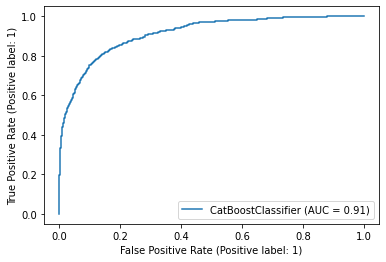

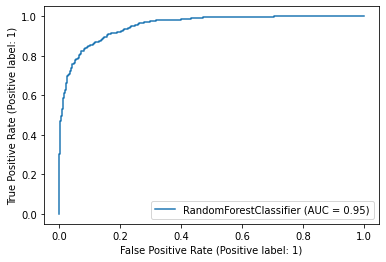

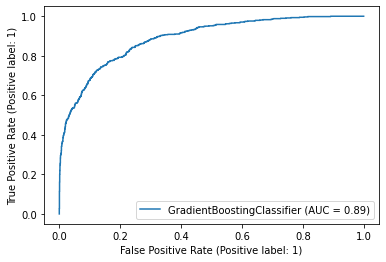

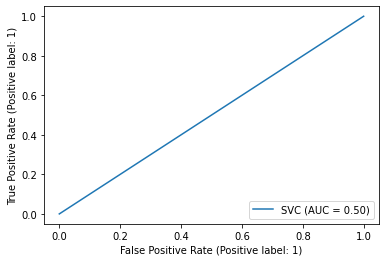

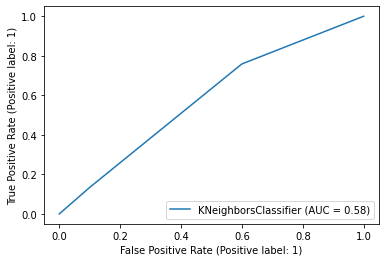

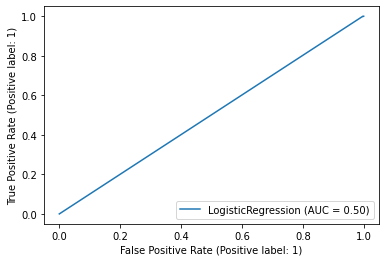

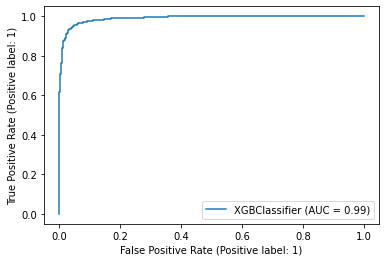

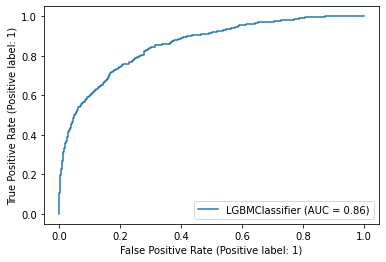

In [40]:
# Evaluate model using Area under Curve to evaluate best performed model

plot_roc_curve(cat, x_test, y_test)
plot_roc_curve(rand, x_test, y_test)
plot_roc_curve(model_grb, x_test, y_test)
plot_roc_curve(svc, x_test, y_test)
plot_roc_curve(knn, x_test, y_test)
plot_roc_curve(Lr_s, x_test, y_test)
plot_roc_curve(xgb, x_test, y_test)
plot_roc_curve(lgbm_model, x_test, y_test)
plt.show()


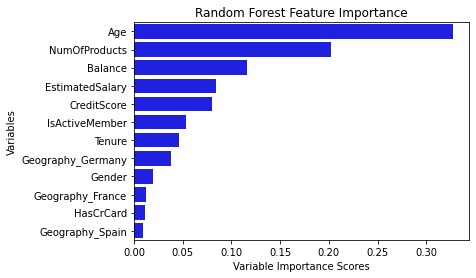

In [41]:
#feature importance of random forest model i.e the most importance predictive feature (variables) in the model performance
feature_index = data_cleaned.loc[:, x.columns ]

feature_importance = pd.Series(rand.feature_importances_,
                               index=feature_index.columns).sort_values(ascending=False)

sns.barplot(x = feature_importance, y = feature_importance.index, color='b')
plt.xlabel('Variable Importance Scores')
plt.ylabel('Variables')
plt.title('Random Forest Feature Importance')
plt.show()

In [42]:
# DEPLOYMENT STAGE

In [43]:
# saving the model
import pickle
pickle_out = open("classifier.pkl", mode = "wb")
pickle.dump(rand, pickle_out)
pickle_out.close()

In [44]:
# installing packages
#We have installed 3 libraries here. pyngrok is a python wrapper for ngrok which helps to open secure tunnels from public URLs to localhost.
#This will help us to host our web app. Streamlit will be used to make our web app.
!pip install -q pyngrok

In [53]:
!pip install -q streamlit

In [46]:
!pip install -q streamlit_ace

In [47]:
data_cleaned.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [48]:
#CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited

In [50]:
%%writefile app.py
import pickle
import streamlit as st

# loading the trained model
pickle_in = open('classifier.pkl', 'rb')
classifier = pickle.load(pickle_in)


@st.cache()
# defining the function which will make the prediction using the data which the user inputs
def prediction(CreditScore, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary,
               Geography_France, Geography_Germany, Geography_Spain):
    # Pre-processing user input
    if Gender == "Male":
        Gender = 0
    else:
        Gender = 1

    if HasCrCard == "No":
        HasCrCard = 0
    else:
        HasCrCard = 1

    if IsActiveMember == "No":
        IsActiveMember = 0
    else:
        IsActiveMember = 1

    if Geography_France == "Yes":
        Geography_France = 1
    else:
        Geography_France = 0

    if Geography_Spain == "Yes":
        Geography_Spain = 1
    else:
        Geography_Spain = 0

    if Geography_Germany == "Yes":
        Geography_Germany = 1
    else:
        Geography_Germany = 0

    # Making predictions
    prediction = classifier.predict(
        [[CreditScore, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary,
          Geography_France, Geography_Germany, Geography_Spain]])

    if prediction == 1:
        pred = 'Leave!'
    else:
        pred = 'Stay!'
    return pred


# this is the main function in which we define our webpage
def main():
    # front end elements of the web page
    html_temp = """
    <div style ="background-color:blue;padding:13px">
    <h1 style ="color:black;text-align:center;">Streamlit Bank Customer Churn Prediction ML App</h1>
    </div>
    <p style ="color:white;text-align:left;">Welcome to my App!</p>
    """

    # display the front end aspect
    st.markdown(html_temp, unsafe_allow_html=True)

    # following lines create boxes in which user can enter data required to make prediction
    Gender = st.selectbox("Customer's Gender", ("Male", "Female"))
    Age = st.number_input("Customer's Age")
    NumOfProducts = st.selectbox("Total Number of Bank Product The Customer Uses", ("1", "2", "3", "4"))
    Tenure = st.selectbox("Number of Years The Customer Has Been a Client",
                          ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"))
    HasCrCard = st.selectbox('Does The Customer has a Credit Card?', ("Yes", "No"))
    IsActiveMember = st.selectbox('Is The Customer an Active Member?', ("Yes", "No"))
    EstimatedSalary = st.number_input("Estimated Salary of Customer")
    Balance = st.number_input("Customer's Account Balance")
    CreditScore = st.number_input("Customer's Credit Score")
    Geography_France = st.selectbox('Is the Customer From France?', ("Yes", "No"))
    Geography_Spain = st.selectbox('Is the Customer From Spain?', ("Yes", "No"))
    Geography_Germany = st.selectbox('Is the Customer From Germany?', ("Yes", "No"))

    result = ""

    # when 'Predict' is clicked, make the prediction and store it
    if st.button("Predict"):
        result = prediction(CreditScore, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember,
                            EstimatedSalary, Geography_France, Geography_Germany, Geography_Spain)
        st.success('The Customer will {}'.format(result))


if __name__ == '__main__':
    main()

Writing app.py


'streamlit' is not recognized as an internal or external command,
operable program or batch file.
